In [1]:
import pyodbc
import os
import pandas as pd

pd.set_option("display.max_columns", 500)

from zipfile import ZipFile

import numpy as np
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
from calendar import month_name, different_locale


# mdb_to_df

In [2]:
def mdb_to_df(file_name, sql):

    conn_str = (
        r"DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};" fr"DBQ={file_name};"
    )
    print(conn_str)
    cnxn = pyodbc.connect(conn_str)

    df = pd.read_sql(sql, cnxn)

    print(f"{file_name} Loaded")
    return df


# Read SUM

In [3]:
def read_sum(period):
    usecols_sum = """
    SELECT CDbl(TimeOn) AS TOn, CDbl(TimeOff) AS TOff,
    StationNr, Alarmcode, ID, Parameter
    FROM tblAlarmLog WHERE TimeOff IS NOT NULL
    union
    SELECT CDbl(TimeOn) AS TOn, TimeOff AS TOff,
    StationNr, Alarmcode, ID, Parameter
    FROM tblAlarmLog WHERE TimeOff IS NULL
    """

    file_name = f"../DATA/SUM/{period}-sum.mdb"

    alarms = mdb_to_df(file_name=file_name, sql=usecols_sum)

    alarms["TOn"] = sqldate_to_datetime(alarms["TOn"])
    alarms["TOff"] = sqldate_to_datetime(alarms["TOff"])

    alarms.rename(columns={"TOn": "TimeOn", "TOff": "TimeOff"}, inplace=True)

    alarms = alarms[alarms.StationNr >= 2307405]

    alarms = alarms[alarms.StationNr <= 2307535].reset_index(drop=True)

    alarms.dropna(subset=["Alarmcode"], inplace=True)

    alarms.reset_index(drop=True, inplace=True)

    alarms.Alarmcode = alarms.Alarmcode.astype(int)

    return alarms


def sqldate_to_datetime(column):

    try:

        column = column.str.replace(",", ".").astype(float)
    except:
        pass

    day_parts = np.modf(column.loc[~column.isna()])

    column = column.fillna(pd.NaT)

    column.loc[column.notna()] = (
        dt(1899, 12, 30)
        + day_parts[1].astype("timedelta64[D]", errors="ignore")
        + (day_parts[0] * 86400000).astype("timedelta64[ms]", errors="ignore")
    )

    column = column.fillna(pd.NaT)

    return column


# Cascade

In [4]:
# Determine alarms real periods
def cascade(df):

    df.reset_index(inplace=True, drop=True)
    df["TimeOffMax"] = df.TimeOff.cummax().shift()

    df.at[0, "TimeOffMax"] = df.at[0, "TimeOn"]

    return df


# looping through turbines and applying cascade method
def apply_cascade(result_sum):

    # Sort by alarm ID
    result_sum.sort_values(["ID"], inplace=True)
    df = result_sum.groupby("StationId").apply(cascade)

    mask_root = df.TimeOn.values >= df.TimeOffMax.values
    mask_children = (df.TimeOn.values < df.TimeOffMax.values) & (
        df.TimeOff.values > df.TimeOffMax.values)
    mask_embedded = df.TimeOff.values <= df.TimeOffMax.values

    df.loc[mask_root, "NewTimeOn"] = df.loc[mask_root, "TimeOn"]
    df.loc[mask_children, "NewTimeOn"] = df.loc[mask_children, "TimeOffMax"]
    df.loc[mask_embedded, "NewTimeOn"] = df.loc[mask_embedded, "TimeOff"]

    df.drop(columns=["TimeOffMax"], inplace=True)

    df.reset_index(inplace=True, drop=True)

    TimeOff = df.TimeOff
    NewTimeOn = df.NewTimeOn

    df["RealPeriod"] = abs(TimeOff - NewTimeOn)

    mask_siemens = df["Error Type"] == 1
    mask_tarec = df["Error Type"] == 0

    df["Period Siemens(s)"] = df[mask_siemens].RealPeriod  # .dt.seconds
    df["Period Tarec(s)"] = df[mask_tarec].RealPeriod  # .dt.seconds
    # df['RealPeriod'] = df['RealPeriod'].dt.seconds

    return df


# Periods

In [5]:
def read_cnt_timestamp(file_name):
    usecols_cnt = '''TimeStamp, StationId'''

    sql_cnt = f"Select {usecols_cnt} FROM tblSCTurCount;"

    cnt = mdb_to_df(file_name=file_name, sql=sql_cnt)

    cnt['TimeStamp'] = pd.to_datetime(cnt['TimeStamp'],
                                      format='%m/%d/%y %H:%M:%S')

    return cnt

In [6]:
def get_month_name(month_no, locale):
    with different_locale(locale):
        return month_name[month_no].capitalize()


period = input('period ex: "2020-07"') or '2020-07'

period_dt = dt.strptime(period, "%Y-%m")
period_month = period_dt.month
period_month_name = get_month_name(period_month, 'french')
period_year = period_dt.year

days_in_period = pd.Period(f'{period}').days_in_month

previous_period_dt = period_dt + relativedelta(months=-1)
previous_period = previous_period_dt.strftime("%Y-%m")

lastday_period_dt = period_dt + relativedelta(months=1, days=-1)
lastday_period = lastday_period_dt.strftime("%Y-%m-%d")

lastday_previous_period_dt = period_dt + relativedelta(days=-1)
lastday_previous_period = lastday_previous_period_dt.strftime("%Y-%m-%d")

days_to_previous_period = len(
    pd.date_range(f'{period_year}-01-01', lastday_previous_period_dt))

currentMonth = dt.now().month
currentYear = dt.now().year
currentPeriod = f'{currentYear}-{str(currentMonth).zfill(2)}'
currentPeriod_dt = dt.strptime(currentPeriod, "%Y-%m")

cnt_timestamp = read_cnt_timestamp(
    f'../Availability_Warranty_Dash/monthly_data/uploads/{period}/{period}-cnt.mdb'
)

period_start = pd.Timestamp(f'{period}-01 00:10:00.000')
period_end = cnt_timestamp.TimeStamp.max()

period, period_start, period_end


DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../Availability_Warranty_Dash/monthly_data/uploads/2021-10/2021-10-cnt.mdb;
../Availability_Warranty_Dash/monthly_data/uploads/2021-10/2021-10-cnt.mdb Loaded


('2021-10', Timestamp('2021-10-01 00:10:00'), Timestamp('2021-11-01 00:00:00'))

# Import last period cumul

In [7]:
df_last_ax1 = pd.read_excel(
    f'./input/{previous_period}/output_xlsxwriter.xlsx',
    sheet_name='ax1',
    index_col=0)

last_boost_cumul = df_last_ax1.at['Indicateurs annuels :', 'Power Boost en MWh']
last_ratio_cumul = df_last_ax1.at['Indicateurs annuels :', 'Performance moyenne des turbines']
last_mtbf_cumul = df_last_ax1.at['Indicateurs annuels :', 'MTBF - Mean Time Between Failure']
last_mttr_cumul = df_last_ax1.at['Indicateurs annuels :', 'MTTR - Mean Time To Repair']
last_mtti_cumul = df_last_ax1.at['Indicateurs annuels :', 'MTTI - Mean Time To Intervention']
last_onee_cumul = df_last_ax1.at['Indicateurs annuels :', 'Compteurs ONEE MWh']

In [8]:
df_last_ax1

LTA-Lost Time  Indispo. Energie Total %  \
Indicateurs annuels :                      0                      2.94   
Indicateurs du mois 2021-09 :              0                      2.61   

                               Indispo. Energie Tarec %  \
Indicateurs annuels :                               0.2   
Indicateurs du mois 2021-09 :                       0.3   

                               Indispo. Energie Siemens %  \
Indicateurs annuels :                                2.73   
Indicateurs du mois 2021-09 :                        2.32   

                               Indispo. Temps Total %  Indispo. Temps Tarec %  \
Indicateurs annuels :                            3.35                    0.68   
Indicateurs du mois 2021-09 :                    3.39                    0.81   

                               Indispo. Temps Siemens %  \
Indicateurs annuels :                              2.67   
Indicateurs du mois 2021-09 :                      2.57   

                               Indispo. Temps ONEE %  Indispo. Temps Ebop %  \
Indicateurs annuels :                              0                      0   
Indicateurs du mois 2021-09 :                      0                      0   

                               Pertes élctriques en MWh  Power Boost en MWh  \
Indicateurs annuels :                          21470.10            10419.17   
Indicateurs du mois 2021-09 :                   2049.94             1711.06   

                               Performance moyenne des turbines  \
Indicateurs annuels :                                    100.56   
Indicateurs du mois 2021-09 :                            103.96   

                               MTBF - Mean Time Between Failure  \
Indicateurs annuels :                                     34.57   
Indicateurs du mois 2021-09 :                             61.46   

                               MTTR - Mean Time To Repair  \
Indicateurs annuels :                               10.05   
Indicateurs du mois 2021-09 :                       22.15   

                               MTTI - Mean Time To Intervention  \
Indicateurs annuels :                                      5.73   
Indicateurs du mois 2021-09 :                              5.59   

                               Compteurs ONEE MWh  
Indicateurs annuels :                  1013433.84  
Indicateurs du mois 2021-09 :            95172.63

# ONEE

In [9]:
onee_tah = pd.read_table(f'./input/{period}/CCH TAREC TR NORM {str(period_month).zfill(2)} {period_year}.XLS')
onee_nord = pd.read_table(f'./input/{period}/CCH TAREC NORD NORM {str(period_month).zfill(2)} {period_year}.XLS')

onee = onee_tah.append(onee_nord)

onee_received = onee['kWh-Rec'].sum()/6/1000

In [ ]:
onee_tah = pd.read_excel(
    f'./input/{period}/CCH TAREC TR NORM {str(period_month).zfill(2)} {period_year}.xlsx')
onee_nord = pd.read_excel(
    f'./input/{period}/CCH TAREC NORD NORM {str(period_month).zfill(2)} {period_year}.xlsx')

onee = onee_tah.append(onee_nord)

onee_received = onee['kWh-Rec'].sum()/6/1000


In [ ]:
onee.groupby(['Date', 'Time']).sum()['kWh-Del'].max()


In [12]:
onee_received

74894.303

In [10]:
# 95172.63

onee_period = float(input("onee_period") or onee_received)

if period_month == 1:
    onee_cumul = onee_period
else:
    onee_cumul = last_onee_cumul + onee_period


In [11]:
last_onee_cumul

1013433.84

# df ax 19 Performance ratio 

In [10]:

# df_ax19 = pd.read_html(f'./input/{period}/TAREC REPORTING.html', thousands=' ', decimal=',')[0]

# df_ax19['Turbine'] = df_ax19['Turbine'].str.extract(r'\[[^\d]*(\d+)[^\d]*\]').values.astype(int)

# df_ax19 = df_ax19[['Turbine', 'Ratio']]

# df_ax19.Ratio.mean()

# # last_ratio_cumul = input('last_ performance_ratio_cumul') or 94.846

# ratio_period = df_ax19.Ratio.mean()

# ratio_cumul = (last_ratio_cumul*days_to_previous_period + ratio_period*days_in_period)/(days_to_previous_period+days_in_period)

# df_ax19

# Calcul mois

In [13]:
df = pd.read_csv(
    f"../Availability_Warranty_Dash/monthly_data/results/{period}-Availability.csv",
    decimal=",",
    sep=";",
)
df.columns = [
    "_".join(str(v) for v in tup) if type(tup) is tuple else tup
    for tup in df.columns
]
df.TimeStamp = pd.to_datetime(df.TimeStamp)
df.to_pickle(f"../Data/results/{period}.pkl")


In [12]:
import pandas as pd

for i in range(1, 12):
    
    period = f'2020-{str(i).zfill(2)}'
    df = pd.read_csv(f'../Availability_Warranty_Dash/monthly_data/results/{period}-Availability.csv',
                        decimal=',', sep=';')
    df.columns = ['_'.join(str(v) for v in tup) if type(tup) is tuple else tup for tup in df.columns]
    df.TimeStamp = pd.to_datetime(df.TimeStamp)
    df.to_pickle(f'../Data/results/{period}.pkl')

In [14]:
results = pd.read_pickle(f"../DATA/results/{period}.pkl")
results["StationId"] = results["StationId"] - 2307404


In [15]:
alarms = read_sum(period)
alarms.rename(columns={"StationNr": "StationId"}, inplace=True)
alarms["StationId"] = alarms["StationId"] - 2307404


DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2021-10-sum.mdb;
../DATA/SUM/2021-10-sum.mdb Loaded


In [16]:
results.head(2)


StationId           TimeStamp  RealPeriod  Period 0(s)  Period 1(s)  \
0          1 2021-10-01 00:10:00         0.0          0.0          0.0   
1          1 2021-10-01 00:20:00         0.0          0.0          0.0   

  UK Text  Duration 2006(s)  wtc_kWG1Tot_accum  wtc_kWG1TotE_accum  \
0       0               0.0              150.0               150.0   
1       0               0.0              148.0               148.0   

   wtc_ActPower_min  wtc_ActPower_max  wtc_ActPower_mean  Duration 115(s)  \
0             648.0            1298.0             897.79              0.0   
1             447.0            1196.0             884.22              0.0   

   Duration 20-25(s)  wtc_AcWindSp_mean  wtc_ActualWindDirection_mean  \
0                0.0               7.50                         55.06   
1                0.0               7.29                         53.21   

   met_WindSpeedRot_mean_38  met_WindSpeedRot_mean_39  \
0                      7.01                      7.01   
1                      7.42                      7.43   

   met_WindSpeedRot_mean_246  met_WinddirectionRot_mean_38  \
0                       6.23                         48.51   
1                       7.15                         46.17   

   met_WinddirectionRot_mean_39  met_WinddirectionRot_mean_246  \
0                         46.49                          39.28   
1                         44.29                          34.09   

   wtc_PowerRed_timeon   Epot  Correction Factor  Available Turbines   EL  \
0                  0.0  150.0                1.0               126.0  0.0   
1                  0.0  148.0                1.0               128.0  0.0   

   ELX  ELNX  EL 115  EL 20-25  EL_115_left  EL_indefini  prev_AcWindSp  \
0  0.0   0.0     0.0       0.0          0.0          0.0            NaN   
1  0.0   0.0     0.0       0.0          0.0          0.0            NaN   

   next_AcWindSp  prev_ActPower_min  next_ActPower_min  prev_Alarme  \
0           6.75                NaN              354.0          NaN   
1           7.54                NaN              523.0          NaN   

   next_Alarme  DiffV1  DiffV2  EL_PowerRed  EL_2006  EL_wind  \
0          0.0     NaN   -0.75          0.0      0.0      NaN   
1          0.0     NaN    0.26          0.0      0.0      NaN   

   Duration lowind(s)  EL_wind_start  Duration lowind_start(s)  \
0                 NaN            NaN                       NaN   
1                 NaN            NaN                       NaN   

   EL_alarm_start  Duration alarm_start(s)  EL_indefini_left  EL_Misassigned  
0             NaN                      NaN               0.0             0.0  
1             NaN                      NaN               0.0             0.0

In [17]:
# abbreviations
Frame = pd.DataFrame
c1 = "Alarmcode"
c2 = "Error Group"

error_group = pd.concat(
    [
        Frame({c1: range(901, 2101), c2: "System"}),
        Frame({c1: range(2101, 3000), c2: "Generator"}),
        Frame({c1: range(3100, 4000), c2: "Hub"}),
        Frame({c1: range(4100, 5000), c2: "Gear"}),
        Frame({c1: range(5000, 6000), c2: "Grid"}),
        Frame({c1: range(6100, 7000), c2: "Rotor"}),
        Frame({c1: range(7100, 8000), c2: "Hydraulics"}),
        Frame({c1: range(8000, 8400), c2: "Environement"}),
        Frame({c1: range(8450, 9000), c2: "Turbine cond..."}),
        Frame({c1: range(9100, 10000), c2: "Brake"}),
        Frame({c1: range(10100, 11000), c2: "Yaw"}),
        Frame({c1: range(11100, 12000), c2: "PFC"}),
        Frame({c1: range(12100, 13000), c2: "Transformer"}),
        Frame({c1: range(13000, 14000), c2: "Converter-1"}),
        Frame({c1: range(14000, 15000), c2: "Gen.inverter"}),
        Frame({c1: range(15000, 16000), c2: "Grid inverter"}),
        Frame({c1: range(16000, 17000), c2: "Main bearing"}),
        Frame({c1: range(17000, 18300), c2: "Converter-2"}),
        Frame({c1: range(62001, 64000), c2: "Controller"}),
        Frame({c1: range(64000, 65200), c2: "MISCELLANEOUS"}),
    ]
)


In [18]:
reorder = [
    "System",
    "Generator",
    "Hub",
    "Gear",
    "Grid",
    "Rotor",
    "Hydraulics",
    "Environement",
    "Turbine cond...",
    "Brake",
    "Yaw",
    "PFC",
    "Transformer",
    "Converter-1",
    "Gen.inverter",
    "Grid inverter",
    "Main bearing",
    "Converter-2",
    "Controller",
    "Miscellaneous",
]


In [19]:
error_list = pd.read_excel(r"Error_Type_List_Las_Update_151209.xlsx",
                           usecols=lambda x: x != "Type Selected")

error_list.Alarmcode = error_list.Alarmcode.astype(int)  # ,errors='ignore'

error_list.drop_duplicates(subset=["Alarmcode"], inplace=True)

error_list = error_list.merge(error_group, on="Alarmcode", how="left")


In [20]:
# ------------------------------------------------------------------------
""" label scada alarms with coresponding error type
and only keep alarm codes in error list"""
result_sum = pd.merge(alarms,
                      error_list,
                      on="Alarmcode",
                      how="inner",
                      sort=False)

# Remove warnings
result_sum = result_sum.loc[result_sum["Error Type"].isin([1, 0])]

# ------------------------------Fill NA TimeOff-------------------------------------

print(f"TimeOff NAs = {result_sum.TimeOff.isna().sum()}")

if result_sum.TimeOff.isna().sum():
    print(f'earliest TimeOn when TimeOff is NA= \
        {result_sum.query("TimeOff.isna()").TimeOn.min()}')

result_sum.TimeOff.fillna(period_end, inplace=True)

# apply cascade
alarms_result_sum = apply_cascade(result_sum)

# only keep  parent alarms
parent_result_sum = alarms_result_sum.query("TimeOn == NewTimeOn")

# dash duree
main_result_sum = alarms_result_sum.query("RealPeriod > @pd.Timedelta(0)")
# main_result_sum['ALL duree'] = main_result_sum['TimeOff'] -main_result_sum['TimeOn']


TimeOff NAs = 7
earliest TimeOn when TimeOff is NA=         2021-10-24 20:02:55


In [388]:
alarms.query('Alarmcode == 1029')

Empty DataFrame
Columns: [TimeOn, TimeOff, StationId, Alarmcode, ID, Parameter]
Index: []

## Power Boost

In [21]:
def read_boost(file_name):
    usecols_cnt = """TimeStamp, StationId, wtc_BoostKWh_endvalue"""

    sql_cnt = f"Select {usecols_cnt} FROM tblSCTurCount;"

    cnt = mdb_to_df(file_name=file_name, sql=sql_cnt)

    cnt["TimeStamp"] = pd.to_datetime(cnt["TimeStamp"],
                                      format="%m/%d/%y %H:%M:%S")

    return cnt


def boost_endvalue_check(df):
    df = df.reset_index().sort_values("TimeStamp")
    df.drop("index", axis=1, inplace=True)
    clmn = df["wtc_BoostKWh_endvalue"]
    x = (clmn.iat[-1] - clmn.iat[0]) / 1000
    # df = df.diff().query('wtc_BoostKWh_endvalue < 0')
    if x < 0:
        return 0
    else:
        return x


In [22]:
# last_boost_cumul = input('last_boost_cumul') or 3458.1

boost = read_boost(
    f"../Availability_Warranty_Dash/monthly_data/uploads/{period}/{period}-cnt.mdb"
)

boost_period = (boost.groupby("StationId").apply(
    lambda df: boost_endvalue_check(df)).sum())

if period_month == 1:
    boost_cumul = boost_period
else:
    boost_cumul = last_boost_cumul + boost_period


DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../Availability_Warranty_Dash/monthly_data/uploads/2021-10/2021-10-cnt.mdb;
../Availability_Warranty_Dash/monthly_data/uploads/2021-10/2021-10-cnt.mdb Loaded


In [23]:
boost_period, boost_cumul

(218.02415673828125, 10637.194156738282)

## MTBF MTTR 

In [24]:
manual_stop = [
    1001,
    1002,
    1005,
    1007,
    1008,
    1009,
    1015,
    1016,
    1017,
    1021,
    1025,
    1026,
    1027,
    8216,
    8217,
    8222,
]


In [25]:
query = '(Alarmcode not in @manual_stop) & (RealPeriod >= @pd.Timedelta("2H"))'

freq_period = len(main_result_sum.query(query))

duree_period = (main_result_sum.query(query)
                               .RealPeriod
                               .sum().total_seconds()
                               / 3600)

mtbf_period = (days_in_period * 24 * 131 - duree_period) / freq_period / 24
mttr_period = duree_period/freq_period

mtbf_period, mttr_period

(72.97275629166667, 20.72657627272727)

In [26]:
# Generate the new calculated MTTBF and MTTR for each error group

MTBF_MTTR_cat = (main_result_sum.query(query).groupby('Error Group').agg(
    duree=('RealPeriod', lambda x: x.sum().total_seconds() / 3600),
    freq=('TimeOn', 'count'),
).rename_axis('Catégorie'))

temps_total_period = days_in_period * 24 * 131

duree_period = MTBF_MTTR_cat['duree']
freq_period = MTBF_MTTR_cat['freq']

MTBF_MTTR_cat['MTTR en h'] = duree_period / freq_period

MTBF_MTTR_cat['MTBF en j'] = (temps_total_period -
                              duree_period) / (freq_period * 24)


In [27]:
MTBF_MTTR_cat

duree  freq  MTTR en h    MTBF en j
Catégorie                                             
Controller     80.608612     9   8.956512   450.849034
Converter-1    62.715556     6  10.452593   676.397809
Environement    5.943056     2   2.971528  2030.376186
Gear           30.525555     5   6.105111   811.945620
Hub           128.048334    19   6.739386   213.456034
Hydraulics     26.033334     3   8.677778  1353.305093
System        778.566692     8  97.320837   503.569965
Yaw            27.520556     3   9.173519  1353.284437

## MTTI

In [28]:
def mtti(df, turbine, alarms):

    # df = main_result_sum.query('StationId == @turbine')
    df = (df.loc[(df.TimeOn == df.NewTimeOn).shift(-1).fillna(True)]
            .query('TimeOn != NewTimeOn').assign(root=False)
            .append(df.query('TimeOn == NewTimeOn').assign(root=True))
            .sort_values('ID'))

    df.loc[(df.root == False).shift(-1).fillna(False), 'TimeOff'] = df.loc[(df.root == False)]['TimeOff'].values
    df['RealPeriod'] = df['TimeOff'] - df['TimeOn']

    df.drop(df.loc[df.root == False].index, inplace=True)

    df2 = alarms.query('StationId == @turbine & Alarmcode == 50000')

    df = (df2.append(df).sort_values('TimeOn').reset_index(drop=True))

    df = df.query('Alarmcode not in @manual_stop') 

    df = df.loc[(df['Alarmcode']).shift() != (df['Alarmcode'])]

    df = cascade(df)

    mask_root = (df.TimeOn.values >= df.TimeOffMax.values)
    mask_children = (df.TimeOn.values < df.TimeOffMax.values) & (
        df.TimeOff.values > df.TimeOffMax.values)
    mask_embedded = (df.TimeOff.values <= df.TimeOffMax.values)

    df.loc[mask_root, 'NewTimeOn'] = df.loc[mask_root, 'TimeOn']
    df.loc[mask_children, 'NewTimeOn'] = df.loc[mask_children, 'TimeOffMax']
    df.loc[mask_embedded, 'NewTimeOn'] = df.loc[mask_embedded, 'TimeOff']

    
    df.drop(df.query('TimeOn == NewTimeOn & Alarmcode == 50000').index, inplace=True)

    mask = (df.Alarmcode == 50000).shift(-1, fill_value=False)

    df.loc[mask, 'TimeTI'] = df.loc[(df.Alarmcode == 50000), 'TimeOn'].values

    df.loc[mask, 'TimeTI'] = df.loc[mask, 'TimeTI'] - df.loc[mask, 'TimeOn']

    df['TimeTI'] = df['TimeTI'].astype('timedelta64[ns]')

    return df


In [29]:
mtti_df = main_result_sum.groupby('StationId').apply(lambda x: mtti(x, x.name, alarms)).reset_index(drop=True)
mtti_df


TimeOn                 TimeOff  StationId  Alarmcode  \
0   2021-10-01 05:05:18.999 2021-10-01 05:40:39.000          1       3130   
1   2021-10-08 07:12:51.000 2021-10-08 12:14:51.000          1      13135   
2   2021-10-08 08:38:29.153 2021-10-08 09:27:09.356          1      50000   
3   2021-10-11 05:05:15.000 2021-10-11 05:08:43.000          1       3130   
4   2021-10-05 20:06:25.000 2021-10-05 20:09:53.000          2       3130   
..                      ...                     ...        ...        ...   
643 2021-10-02 02:14:15.000 2021-10-02 02:17:36.999        130       3130   
644 2021-10-24 06:31:34.999 2021-10-24 06:32:37.999        130      13902   
645 2021-10-24 06:34:39.000 2021-10-24 06:54:40.000        130       7105   
646 2021-10-27 05:34:12.000 2021-10-27 05:37:35.999        130       3130   
647 2021-10-05 18:55:30.000 2021-10-05 18:58:58.000        131       3130   

          ID                                          Parameter  \
0    5146970                                                ...   
1    5187689                                                ...   
2    5187829                                                ...   
3    5200105                                                ...   
4    5160597                                                ...   
..       ...                                                ...   
643  5151141                                                ...   
644  5275913                                                ...   
645  5276055                                                ...   
646  5291612                                                ...   
647  5160137                                                ...   

                           UK Text Error Type  Error Group  \
0                Pitch lubrication          0          Hub   
1          Fuse blown, Grid filter          1  Converter-1   
2                              NaN        NaN          NaN   
3                Pitch lubrication          0          Hub   
4                Pitch lubrication          0          Hub   
..                             ...        ...          ...   
643              Pitch lubrication          0          Hub   
644  Converter tripped, Auto Start          1  Converter-1   
645  Low pitch oil pressure, start          1   Hydraulics   
646              Pitch lubrication          0          Hub   
647              Pitch lubrication          0          Hub   

                  NewTimeOn             RealPeriod      Period Siemens(s)  \
0   2021-10-01 05:05:18.999 0 days 00:35:20.001000                    NaT   
1   2021-10-08 07:12:51.000        0 days 05:02:00 0 days 05:01:51.999000   
2   2021-10-08 09:27:09.356                    NaT                    NaT   
3   2021-10-11 05:05:15.000        0 days 00:03:28                    NaT   
4   2021-10-05 20:06:25.000        0 days 00:03:28                    NaT   
..                      ...                    ...                    ...   
643 2021-10-02 02:14:15.000 0 days 00:03:21.999000                    NaT   
644 2021-10-24 06:31:34.999        0 days 00:01:03        0 days 00:01:03   
645 2021-10-24 06:34:39.000        0 days 00:20:01        0 days 00:20:01   
646 2021-10-27 05:34:12.000 0 days 00:03:23.999000                    NaT   
647 2021-10-05 18:55:30.000        0 days 00:03:28                    NaT   

           Period Tarec(s)  root              TimeOffMax  \
0   0 days 00:12:40.001000  True 2021-10-01 05:05:18.999   
1                      NaT  True 2021-10-01 05:40:39.000   
2                      NaT   NaN 2021-10-08 12:14:51.000   
3          0 days 00:03:28  True 2021-10-08 12:14:51.000   
4          0 days 00:03:28  True 2021-10-01 08:58:03.403   
..                     ...   ...                     ...   
643 0 days 00:03:21.999000  True 2021-10-02 02:14:15.000   
644                    NaT  True 2021-10-02 02:17:36.999   
645                    NaT  True 2021-10-24 06:32:37.999   
646 0 days 00:03:23.9

In [30]:
mtti_period = (mtti_df['TimeTI'].sum() / len(mtti_df.query('Alarmcode == 50000'))).total_seconds()/3600

mtti_period

5.110213534444445

In [31]:
mtti_df['TimeTI'].mean().total_seconds()/3600

5.110213534444445

## Graphe 3 ax5

In [32]:
df_ax5 = (main_result_sum.groupby('Error Group')
                  .agg(Freq=('Alarmcode', 'count'),
                       Durée=('RealPeriod', lambda x: x.sum().total_seconds()/3600))
                  .reindex(reorder)
                  .dropna()
                  .reset_index()
                  )

# df_ax5.plot(kind='bar', x='Error Group', ax=ax5)
df_ax5

Error Group    Freq        Durée
0         System   531.0  1788.861832
1            Hub  1010.0   272.593328
2           Gear    38.0    39.135569
3           Grid    12.0     0.563333
4          Rotor     2.0     2.100833
5     Hydraulics    61.0    39.435002
6   Environement    53.0    22.396945
7          Brake    34.0     4.671125
8            Yaw   213.0    70.340556
9    Converter-1    80.0    67.109998
10    Controller    45.0    85.967514

## Graphe 4 ax6

In [33]:
df_ax6 = (main_result_sum.groupby('Alarmcode')
                .agg(Freq=('Alarmcode', 'count'),
                     Durée=('RealPeriod',
                               lambda x: x.sum().total_seconds()/3600))
                .sort_values('Durée', ascending=False)
                .head(20)
                .reset_index()
                .sort_values('Durée', ascending=False))

# df_ax6.plot(kind='bar', x='Alarmcode', ax=ax6)
df_ax6

Alarmcode  Freq       Durée
0        1001   235  692.770142
1        1109    19  637.462222
2        1008    93  112.666393
3        1017     2   96.983056
4         916     4   87.016969
5        1007    50   80.666386
6        3130   801   72.599995
7        1003     6   53.112223
8        3413    33   44.426389
9        3412    47   39.813055
10      63025     8   36.979167
11      63211     2   35.031111
12       3411    37   28.789166
13      13311     6   26.971389
14      13294     1   26.350556
15       7101    15   25.700556
16       3203    28   24.675557
17      10400   142   22.427501
18      10109    21   21.262777
19       4111    19   19.060291

## ax7

In [34]:
most_categories = (main_result_sum.groupby('Error Group')
                                  .agg({'RealPeriod': np.sum})
                                  .sort_values('RealPeriod', ascending=False)
                                  .index.values)

realperiod_sum = main_result_sum.RealPeriod.sum()
percentage_per_category = (main_result_sum.groupby('Error Group')
                                  .agg(percentage=('RealPeriod',
                                                   lambda x: 100 * x.sum() / realperiod_sum))
                                  .sort_values('percentage', ascending=False))


df_most_categories = main_result_sum.loc[main_result_sum['Error Group'].isin(most_categories)].copy()

df_most_categories['Error Group'] = df_most_categories['Error Group'].astype("category")

df_most_categories['Error Group'].cat.set_categories(most_categories, inplace=True)

df_most_categories.sort_values('Error Group', inplace=True)


# ------------------------------------------------------------------------------------------------
def extract_important_alarms(df):

    df = df.groupby('Alarmcode').agg({'RealPeriod': np.sum}).reset_index()
    
    df['percentage'] = 100 * df['RealPeriod'] / df['RealPeriod'].sum()
    df.sort_values('percentage', ascending=False, inplace=True)
    df['percentage roll'] = df['percentage'].cumsum()
    df.set_index('Alarmcode', inplace=True)


#     for i in range(1,100):
#         if len(df.query('`percentage roll` < @i')) < 3:
#             continue
#         else:
#             df = df.query('`percentage roll` < @i')
#         break

    return df

# ------------------------------------------------------------------------------------------------

df_ax7 = (df_most_categories.groupby('Error Group', sort=False)
                            .apply(lambda x: extract_important_alarms(x))
                            .reset_index()
                            .merge(error_list[['UK Text', 'Alarmcode']], how='left')
         )

# df_ax7 = (df_most_categories.groupby('Error Group')
#                              .apply(lambda x: (x.groupby('Alarmcode')
#                                                 .agg({'RealPeriod': np.sum})
#                                                 .sort_values('RealPeriod')
#                                                 .tail(4)))
#                              .reset_index()
#                              .merge(error_list[['UK Text', 'Alarmcode']]))

# ------------------------------------------------------------------------------------------------
ax7 = ''
for cat in most_categories:
    
    str1_ax7 = ''
    
    for i, row in df_ax7.query('`Error Group` == @cat').iterrows():
        
        Alarmcode = row['Alarmcode']
        UK_Text = row['UK Text']
        Percentage = round(row['percentage'], 1)
                       
        str1_ax7 += f'\n\t-\"{Alarmcode} - {UK_Text} - {Percentage}% \".'
        
    
    str2_ax7 = f"""
La catégorie {cat} - {round(percentage_per_category.loc[cat, 'percentage'], 2)}%, les alarmes les plus importantes sont:{str1_ax7}
    """
    ax7 += str2_ax7
    
worst_mtbf_cat = MTBF_MTTR_cat['MTBF en j'].idxmin()
worst_mtbf = int(MTBF_MTTR_cat['MTBF en j'].min())

ax7 += f'\nLe MTBF le moins bon du mois est celui de la catégorie "{worst_mtbf_cat}" :  {worst_mtbf} jours '


C:\Users\Saad\miniconda3\lib\site-packages\pandas\core\arrays\categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [35]:
# with open("Output.txt", "w", encoding='UTF-8') as text_file:
#     text_file.write(ax7)

## Graph 6 ax9

In [36]:
df_ax9 = pd.merge(
        (results.groupby('StationId')
                       .agg(**{'Durée arrêts': ('RealPeriod', lambda x: x.sum()/3600),
                               'Durée autres': ('Duration 20-25(s)', lambda x: x.sum()/3600)})
                       .sort_values('Durée arrêts', ascending=False)
                 # .head(25)
                 .reset_index()
         ),
         (alarms.groupby('StationId')
                      .agg(**{'Freq arrêts': ('Alarmcode', lambda x: int(x[x == 115].count()/2)),
                              'Freq autres': ('Alarmcode', lambda x: x[x == 20].count())})
                      .reset_index()
         ),
         on='StationId'
        ).sort_values('Durée arrêts', ascending=False).head(20)


df_ax9['Duration_20_25 reel'] = df_ax9['Durée autres']
df_ax9['Durée autres'] = (df_ax9['Duration_20_25 reel'] - df_ax9['Durée arrêts'])
# df_ax9.plot(kind='bar', x='StationId', ax=ax9)

df_ax9

StationId  Durée arrêts  Durée autres  Freq arrêts  Freq autres  \
0          70    744.166667     -0.166667            0            0   
1          41    112.800278     15.936944            8           44   
2          89    109.520833      5.995278            5           23   
3         127     91.930000    131.866667            9           64   
4         116     75.250000     11.804722           33           75   
5          99     69.121039     10.925628            5           51   
6          87     58.852453     19.581436           11           77   
7          54     54.299167     10.773333           27           52   
8         114     52.909722     16.274444           25           91   
9         111     39.536108     13.502503           27           74   
10        117     36.225278     10.857500           19           71   
11        113     35.694167     14.378889           21           67   
12        110     35.447222     14.280000           16           67   
13        107     35.421111     12.484722           19           47   
14        112     35.000833     15.016111           15           72   
15        109     34.387514     12.269708           22           82   
16        108     34.384458     12.022208           17           75   
17        121     29.043333     13.240833           11           44   
18        115     28.208889     14.790833           14           79   
19        118     25.921667     10.631944           17           67   

    Duration_20_25 reel  
0            744.000000  
1            128.737222  
2            115.516111  
3            223.796667  
4             87.054722  
5             80.046667  
6             78.433889  
7             65.072500  
8             69.184167  
9             53.038611  
10            47.082778  
11            50.073056  
12            49.727222  
13            47.905833  
14            50.016944  
15            46.657222  
16            46.406667  
17            42.284167  
18            42.999722  
19            36.553611

In [37]:
df = alarms.query('Alarmcode == 63025').copy()

df['Duree'] = (df['TimeOff'] - df['TimeOn']).dt.total_seconds()


df.sort_values('Duree', ascending=False).head(15).groupby(
    'StationId').sum().sort_values('Duree', ascending=False)[['Duree']]/3600


Duree
StationId           
54         28.073889
20         10.873334
112         8.104445
115         7.490834
113         6.893333
116         4.558611
108         4.456389
110         3.942222

In [38]:
df = alarms.query('Alarmcode == 3413 | Alarmcode == 3411 | Alarmcode == 3412').copy()

df['Duree'] = (df['TimeOff'] - df['TimeOn']).dt.total_seconds()


df.sort_values('Duree', ascending=False).head(15).groupby(
    'StationId').sum().sort_values('Duree', ascending=False)[['Duree']]/3600


Duree
StationId           
96         12.589723
41          6.626389
116         6.023056
39          5.485834
93          5.212778
12          4.872222
37          4.425278
1           3.385834
89          2.892778
47          2.448055
25          2.382222
126         2.332222
33          2.278334
54          1.863889

## Graphe 7 ax10

In [39]:
df_ax10 = (results[['StationId','ELNX', 'EL_indefini_left']]
                .groupby('StationId')
                .sum()
                .sort_values('ELNX', ascending=False)
                .reset_index())

df_ax10[['ELNX', 'EL_indefini_left']] = df_ax10[['ELNX', 'EL_indefini_left']] / 1e3

df_ax10 = round(df_ax10, 2).abs()

df_ax10.rename({'ELNX': 'Energie perdue SGRE'}, inplace=True, axis=1)

df_ax10

StationId  Energie perdue SGRE  EL_indefini_left
0           70               565.91               0.0
1           41                70.38               0.0
2          127                63.92               0.0
3           89                61.75               0.0
4           99                52.62               0.0
..         ...                  ...               ...
126         88                 0.00               0.0
127         48                 0.00               0.0
128         34                 0.00               0.0
129         90                 0.00               0.0
130         59                 0.00               0.0

[131 rows x 3 columns]

## ax11

In [40]:
import unicodedata

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

period_month_name_ascii = remove_accents(period_month_name).upper()

### Convert canvas after manual tidying (unmerge cells & unsplit)

In [41]:
from openpyxl import load_workbook
import openpyxl

filename = f'./input/{period}/PART REPLACED SGRE SERVICE {period_year}.xlsx'

wb = load_workbook(filename=filename)

ws = wb[period_month_name_ascii]

# ws.unmerge_cells('A2:D2')

parts = pd.DataFrame(ws.values)


merged_ranges = [np.subtract(np.array(openpyxl.utils.cell.range_boundaries(str(i))), [1, 1, 0, 0])
                 for i in ws.merged_cells.ranges]


for single_range in merged_ranges:

    parts.iloc[(single_range[1]):(single_range[3]),
               (single_range[0]):(single_range[2])].ffill(inplace=True)


new_header = parts.iloc[7]  # grab the first row for the header
parts = parts[8:]  # take the data less the header row
parts.columns = new_header.rename(None)  # set the header row as the df header

parts.dropna(subset=['DESCRIPTION'], inplace=True)

parts = parts.assign(TURBINE=parts.TURBINE.astype(
    'str').str.rstrip('/').str.split('/')).explode('TURBINE')

# parts.reset_index(drop=True, inplace=True)

# parts.rename(
#     columns={'DESCRIPTION': 'REFERENCE',
#              'DEFECT': 'DESIGNATION',
#              'QTE': 'QTE SORTIE'},
#     inplace=True)


# parts[['DESIGNATION', 'TURBINE']] = parts[['DESIGNATION', 'TURBINE']].apply(
#     lambda s: s.str.upper().str.lstrip('\t'), 1)

# parts['REFERENCE'] = parts['REFERENCE'].str.upper()

# parts['TURBINE'] = parts['TURBINE'].str.extract('(\d+)', expand=False)

# parts = parts.astype({'TURBINE': int, 'QTE SORTIE': int})

parts


TURBINE                       SOLVED ERROR/WORK DONE   DESCRIPTION  \
8         2     Annual service (6th year annual service)   A9B10011190   
9        85                         Inspect UPS Circuit    A9B10011190   
11      114         Gen align (7th year annual service)    A9B10069827   
12      114         Gen align (7th year annual service)    A9B10044880   
13      114         Gen align (7th year annual service)    A9B00018568   
..      ...                                          ...           ...   
260      11                   Reset the UPS by passerror   A9B10011190   
265      99                             Replaced the MC   A9B00400719    
266     123  Replaced the smoke detector F the converter   A9B00083161   
267     123  Replaced the smoke detector F the converter   A9B10075055   
268     123  Replaced the smoke detector F the converter   A9B00083162   

                                       DEFECT QTE  
8    Battery pack (8 pc) for 809.C1 or 809.C2   1  
9    Battery pack (8 pc) for 809.C1 or 809.C2   1  
11                          WIREGUIDE PLASTIC   2  
12                             LADDER SUPPORT   4  
13                       LADDER BRACKET OMEGA   4  
..                                        ...  ..  
260  Battery pack (8 pc) for 809.C1 or 809.C2   1  
265                             Main computer   1  
266              SMOKE DETECTOR  S65  OPTICAL   1  
267                                    fan a3   5  
268             SOCKET F. SMOKE DETECTOR S65R   1  

[213 rows x 5 columns]

In [42]:
filename = f'./input/{period}/PART REPLACED SGRE SERVICE {period_year}.xlsx'

wb = load_workbook(filename=filename)

ws = wb[period_month_name_ascii]

# ws.unmerge_cells('A2:D2')

parts = pd.DataFrame(ws.values)


merged_ranges = [np.subtract(np.array(openpyxl.utils.cell.range_boundaries(str(i))), [1, 1, 0, 0])
                 for i in ws.merged_cells.ranges]


for single_range in merged_ranges:

    parts.iloc[(single_range[1]):(single_range[3]),
               (single_range[0]):(single_range[2])].ffill(inplace=True)


new_header = parts.iloc[7]  # grab the first row for the header
parts = parts[8:]  # take the data less the header row
parts.columns = new_header.rename(None)  # set the header row as the df header

parts.dropna(subset=['DESCRIPTION'], inplace=True)

parts = parts.assign(TURBINE=parts.TURBINE.astype(
    'str').str.rstrip('/').str.split('/'))

parts['QTE'] = parts['QTE'].astype(int)



In [43]:
divmod_arr = np.divmod(parts.QTE.to_numpy(), parts['TURBINE'].str.len().to_numpy())

qte_list = []

for a, b in enumerate(parts['TURBINE'].str.len().to_numpy()):

    empty_arr = np.empty((b), int)

    if b > 1:
        for index, x in np.ndenumerate(empty_arr[:-1]):
            empty_arr[index] = divmod_arr[0][a]

        empty_arr[-1] = divmod_arr[0][a] + divmod_arr[1][a]

    else:
        empty_arr[0] = divmod_arr[0][i]

    qte_list.append(empty_arr.tolist())

In [44]:
parts.reset_index(drop=True, inplace=True)

parts = parts.assign(QTE=pd.Series(qte_list)).explode(['TURBINE', 'QTE'])

parts.rename(
    columns={'DESCRIPTION': 'REFERENCE',
             'DEFECT': 'DESIGNATION',
             'QTE': 'QTE SORTIE'},
    inplace=True)


parts[['DESIGNATION', 'TURBINE']] = parts[['DESIGNATION', 'TURBINE']].apply(
    lambda s: s.str.upper().str.lstrip('\t'), 1)

parts['REFERENCE'] = parts['REFERENCE'].str.upper()

parts['TURBINE'] = parts['TURBINE'].str.extract('(\d+)', expand=False)

parts = parts.astype({'TURBINE': int, 'QTE SORTIE': int})

parts.head(15)


TURBINE                    SOLVED ERROR/WORK DONE     REFERENCE  \
0         2  Annual service (6th year annual service)   A9B10011190   
1        85                      Inspect UPS Circuit    A9B10011190   
2       114      Gen align (7th year annual service)    A9B10069827   
3       114      Gen align (7th year annual service)    A9B10044880   
4       114      Gen align (7th year annual service)    A9B00018568   
5       114      Gen align (7th year annual service)    A9B10037149   
6       121                        Inspect Yaw System   A9B10243060   
7        51                   Ultrasonic Instalation    A9B00019620   
8        51                   Ultrasonic Instalation    A9B00019621   
9       101           Replaced defect Grid filter Fan  A9B100372309   
10      116  Replace lock mechanisme of  Turbine Door   A9B10060257   
10      117  Replace lock mechanisme of  Turbine Door   A9B10060257   
11      116  Replace lock mechanisme of  Turbine Door   A9B10074557   
11      117  Replace lock mechanisme of  Turbine Door   A9B10074557   
12      116  Replace lock mechanisme of  Turbine Door   A9B10018346   

                                 DESIGNATION  QTE SORTIE  
0   BATTERY PACK (8 PC) FOR 809.C1 OR 809.C2           1  
1   BATTERY PACK (8 PC) FOR 809.C1 OR 809.C2           1  
2                          WIREGUIDE PLASTIC           1  
3                             LADDER SUPPORT           1  
4                       LADDER BRACKET OMEGA           1  
5               TERMINAL F/WTC2-3 KK V110-10           1  
6                                  YAW MOTOR           1  
7                                   WINDVANE           1  
8                                 ANEMOMETRE           1  
9                           FAN GRID FILEYER           1  
10                                  PAD LOCK           1  
10                                  PAD LOCK           1  
11                            LOCK MECHANISM           2  
11                            LOCK MECHANISM           3  
12               LOCKING PLATE F DOOR HANDLE           2

In [45]:
parts.query("REFERENCE == 'A9B10243060'")

TURBINE    SOLVED ERROR/WORK DONE    REFERENCE DESIGNATION  QTE SORTIE
6        121        Inspect Yaw System  A9B10243060   YAW MOTOR           1
44        60  Replaced defect Yawmotor  A9B10243060   YAW MOTOR           1
73       102     YawGear 1 Replacement  A9B10243060   YAW MOTOR           1
118      121         Inpect Yaw System  A9B10243060   YAW MOTOR           1

In [46]:
parts.isna().sum()

TURBINE                   0
SOLVED ERROR/WORK DONE    0
REFERENCE                 0
DESIGNATION               0
QTE SORTIE                0
dtype: int64

In [47]:
# parts = pd.read_excel(
#     f'./input/{period}/PART REPLACED SGRE SERVICE {period_year}.xlsx', header=7, sheet_name=period_month_name_ascii)

# parts['REFERENCE'] = parts['REFERENCE'].str.upper()

# parts.rename(
#     columns={'N° TURBINE': 'TURBINE'},
#     inplace=True)

# parts['TURBINE'] = parts['TURBINE'].str.upper().str.strip('T00')

# parts = parts.loc[parts.TURBINE != '']

# parts = parts.astype({'TURBINE':int, 'QTE SORTIE': int})

# parts['DESIGNATION'] = parts['DESIGNATION'].str.upper().str.lstrip('\t')


In [48]:

df_ax11_last = pd.read_excel(f'./results/{previous_period}/TB Performance {previous_period}.xlsx', sheet_name='Feuil3', skiprows=1,
                       usecols='C:E')


df_ax11 = parts.rename(
    columns={'REFERENCE': 'item', 'QTE SORTIE': period_month_name})

df_ax11 = df_ax11.groupby('item').sum().reset_index()[['item', period_month_name]]

# if period_month == 1:

#     df_ax11['Year'] = df_ax11[period_month_name].fillna(0)
#     df_ax11 = df_ax11[['item', 'Year', period_month_name]]
    
# else:
df_ax11 = df_ax11_last.merge(df_ax11, how='outer')[['item', 'Year', period_month_name]]
df_ax11['Year'] = (df_ax11['Year'].fillna(0) + df_ax11[period_month_name].fillna(0))

df_ax11 = df_ax11.fillna(0).astype(int, errors='ignore')

df_ax11


item  Year  Octobre
0    A9B10055151   596        1
1    A9B00573133   171        1
2    A9B10027591    48        0
3    A9B00075055   159        0
4    A9B00019620   236       38
..           ...   ...      ...
242  A9B10074557     5        5
243  A9B10076459     3        3
244  A9B10096836     1        1
245  A9B10107206     3        3
246  A9B10170672     1        1

[247 rows x 3 columns]

## ax12 (retired)

In [49]:
df_ax12 = parts.copy()

df_ax12['TURBINE'] = df_ax12['TURBINE'].astype(str)

df_ax12 = (df_ax12.groupby('DESIGNATION')
                  .agg({'QTE SORTIE': np.sum,
                        'TURBINE': lambda x: set(map(int, x.str.upper().str.lstrip('T00').str.cat(sep=' ').split()))})
                  .reset_index())

max_turbines = set(df_ax10.head(20).StationId.astype(int))
df_ax12['max_turbines'] = df_ax12['TURBINE'].apply(lambda x: x & max_turbines)

df_ax12.sort_values('QTE SORTIE').reset_index(drop=True).to_clipboard()

df_ax12


DESIGNATION  QTE SORTIE  \
0                           AIR VENT 3/8 AUT           3   
1                                 ANEMOMETRE          37   
2   BATTERY PACK (8 PC) FOR 809.C1 OR 809.C2          14   
3     BOTTOM OBSTRUCTION SWITCH SHERPA RD V2           3   
4                           CIRCULATION PUMP           1   
..                                       ...         ...   
61                                  WINDVANE          38   
62                         WIREGUIDE PLASTIC          10   
63            YAW BREAKING MODULE 6 CHANNELS           1   
64                                  YAW GEAR           2   
65                                 YAW MOTOR           5   

                                              TURBINE  \
0                                           {114, 54}   
1   {129, 10, 18, 25, 26, 47, 51, 52, 53, 54, 55, ...   
2   {2, 103, 107, 108, 109, 110, 111, 112, 11, 115...   
3                                     {104, 105, 107}   
4                                               {110}   
..                                                ...   
61  {129, 10, 18, 25, 26, 47, 51, 52, 53, 54, 55, ...   
62      {104, 105, 108, 110, 111, 112, 114, 116, 117}   
63                                              {121}   
64                                         {116, 102}   
65                                {116, 121, 60, 102}   

                                max_turbines  
0                                      {114}  
1                                 {114, 110}  
2   {107, 108, 110, 111, 115, 116, 117, 118}  
3                                      {107}  
4                                      {110}  
..                                       ...  
61                                {114, 110}  
62            {108, 110, 111, 114, 116, 117}  
63                                     {121}  
64                                     {116}  
65                                {121, 116}  

[66 rows x 4 columns]

In [50]:
max_turbines

{23,
 41,
 65,
 70,
 87,
 89,
 98,
 99,
 107,
 108,
 110,
 111,
 113,
 114,
 115,
 116,
 117,
 118,
 121,
 127}

In [51]:
df_ax12 = parts.copy()

df_ax12 = df_ax12.groupby(['DESIGNATION', 'TURBINE']).sum(
).sort_values(['DESIGNATION', 'QTE SORTIE'])

df_ax12


QTE SORTIE
DESIGNATION      TURBINE            
AIR VENT 3/8 AUT 54                1
                 114               2
ANEMOMETRE       10                1
                 51                1
                 55                1
...                              ...
YAW GEAR         116               1
YAW MOTOR        60                1
                 102               1
                 116               1
                 121               2

[201 rows x 1 columns]

In [53]:
parts


TURBINE                       SOLVED ERROR/WORK DONE     REFERENCE  \
0          2     Annual service (6th year annual service)   A9B10011190   
1         85                         Inspect UPS Circuit    A9B10011190   
2        114         Gen align (7th year annual service)    A9B10069827   
3        114         Gen align (7th year annual service)    A9B10044880   
4        114         Gen align (7th year annual service)    A9B00018568   
..       ...                                          ...           ...   
176       11                   Reset the UPS by passerror   A9B10011190   
177       99                             Replaced the MC   A9B00400719    
178      123  Replaced the smoke detector F the converter   A9B00083161   
179      123  Replaced the smoke detector F the converter   A9B10075055   
180      123  Replaced the smoke detector F the converter   A9B00083162   

                                  DESIGNATION  QTE SORTIE  
0    BATTERY PACK (8 PC) FOR 809.C1 OR 809.C2           1  
1    BATTERY PACK (8 PC) FOR 809.C1 OR 809.C2           1  
2                           WIREGUIDE PLASTIC           1  
3                              LADDER SUPPORT           1  
4                        LADDER BRACKET OMEGA           1  
..                                        ...         ...  
176  BATTERY PACK (8 PC) FOR 809.C1 OR 809.C2           1  
177                             MAIN COMPUTER           1  
178              SMOKE DETECTOR  S65  OPTICAL           1  
179                                    FAN A3           1  
180             SOCKET F. SMOKE DETECTOR S65R           1  

[213 rows x 5 columns]

## table 1 ax1 row 2

In [54]:
df_ax1 = pd.DataFrame(columns=df_last_ax1.columns,
                     index=['Indicateurs annuels :', f'Indicateurs du mois {period} :'])
df_ax1 = df_ax1.fillna(0.)

In [55]:
i_period = f'Indicateurs du mois {period} :'

df_ax1.at[i_period, 'Indispo. Temps Total %'] = round(100*results['RealPeriod'].sum()/3600/24/131/days_in_period,2)
df_ax1.at[i_period, 'Indispo. Temps Tarec %'] = round(100*results['Period 0(s)'].sum()/3600/24/131/days_in_period,2)
df_ax1.at[i_period, 'Indispo. Temps Siemens %'] = round(100*results['Period 1(s)'].sum()/3600/24/131/days_in_period,2)

df_ax1.at[i_period, 'Pertes élctriques en MWh'] = round(results.wtc_kWG1TotE_accum.sum()/1000 - onee_period,2)

df_ax1.at[i_period, 'Power Boost en MWh'] = round(boost_period, 2)

# df_ax1.at[i_period, 8] = ratio_period
#
df_ax1.at[i_period, 'MTBF - Mean Time Between Failure']  = round(mtbf_period, 2)
df_ax1.at[i_period, 'MTTR - Mean Time To Repair'] = round(mttr_period, 2)
df_ax1.at[i_period, 'MTTI - Mean Time To Intervention'] = round(mtti_period, 2)
df_ax1.at[i_period, 'Compteurs ONEE MWh'] = round(onee_period, 2)

In [56]:
df_ax1

LTA-Lost Time  Indispo. Energie Total %  \
Indicateurs annuels :                    0.0                       0.0   
Indicateurs du mois 2021-10 :            0.0                       0.0   

                               Indispo. Energie Tarec %  \
Indicateurs annuels :                               0.0   
Indicateurs du mois 2021-10 :                       0.0   

                               Indispo. Energie Siemens %  \
Indicateurs annuels :                                 0.0   
Indicateurs du mois 2021-10 :                         0.0   

                               Indispo. Temps Total %  Indispo. Temps Tarec %  \
Indicateurs annuels :                            0.00                    0.00   
Indicateurs du mois 2021-10 :                    2.47                    0.44   

                               Indispo. Temps Siemens %  \
Indicateurs annuels :                              0.00   
Indicateurs du mois 2021-10 :                      2.03   

                               Indispo. Temps ONEE %  Indispo. Temps Ebop %  \
Indicateurs annuels :                            0.0                    0.0   
Indicateurs du mois 2021-10 :                    0.0                    0.0   

                               Pertes élctriques en MWh  Power Boost en MWh  \
Indicateurs annuels :                              0.00                0.00   
Indicateurs du mois 2021-10 :                   1480.02              218.02   

                               Performance moyenne des turbines  \
Indicateurs annuels :                                       0.0   
Indicateurs du mois 2021-10 :                               0.0   

                               MTBF - Mean Time Between Failure  \
Indicateurs annuels :                                      0.00   
Indicateurs du mois 2021-10 :                             72.97   

                               MTTR - Mean Time To Repair  \
Indicateurs annuels :                                0.00   
Indicateurs du mois 2021-10 :                       20.73   

                               MTTI - Mean Time To Intervention  \
Indicateurs annuels :                                      0.00   
Indicateurs du mois 2021-10 :                              5.11   

                               Compteurs ONEE MWh  
Indicateurs annuels :                         0.0  
Indicateurs du mois 2021-10 :             74894.3

## table 2 ax2

In [57]:

df_ax2_header = ['', '', '', 'Travaux de maintenance']
df_ax2 = pd.DataFrame(columns=['Transformateur', 'Serial Defect', 'Corrosion', 'Inspection Fin de garantie',
                               'FSA', 'Assurance', 'Conformité DNSSI', 'Main Bearing', 'BAX', 'Darwin',
                               'Procédure de securité', 'SMI', 'Exploitation', 'Mesures', 'Audit ENGIE'],
                     index=['Etape terminée', 'Etape en cours'])

In [58]:
df_ax2

Transformateur Serial Defect Corrosion  \
Etape terminée            NaN           NaN       NaN   
Etape en cours            NaN           NaN       NaN   

               Inspection Fin de garantie  FSA Assurance Conformité DNSSI  \
Etape terminée                        NaN  NaN       NaN              NaN   
Etape en cours                        NaN  NaN       NaN              NaN   

               Main Bearing  BAX Darwin Procédure de securité  SMI  \
Etape terminée          NaN  NaN    NaN                   NaN  NaN   
Etape en cours          NaN  NaN    NaN                   NaN  NaN   

               Exploitation Mesures Audit ENGIE  
Etape terminée          NaN     NaN         NaN  
Etape en cours          NaN     NaN         NaN

# Calcul Cumul

In [59]:
cumul_alarms = pd.DataFrame()
cumul_results = pd.DataFrame()

for month in range(1, period_month+1): # range(1, period_month+1):

    period_cumul = f'{str(period_year).zfill(2)}-{str(month).zfill(2)}'
    alarms = read_sum(f'{period_cumul}')

    cumul_alarms = pd.concat([cumul_alarms, alarms])

    # -------------------------------------------------------------------------
    results = pd.read_pickle(f'../DATA/results/{period_cumul}.pkl')
    
    # results = results[['StationId', 'ELNX', 'Duration 115(s)', 'Duration 20-25(s)',
    #                    'Period 0(s)', 'Period 1(s)', 'RealPeriod',
    #                    'EL_indefini_left']]

    cumul_results = pd.concat([cumul_results, results])


DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2021-01-sum.mdb;
../DATA/SUM/2021-01-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2021-02-sum.mdb;
../DATA/SUM/2021-02-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2021-03-sum.mdb;
../DATA/SUM/2021-03-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2021-04-sum.mdb;
../DATA/SUM/2021-04-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2021-05-sum.mdb;
../DATA/SUM/2021-05-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2021-06-sum.mdb;
../DATA/SUM/2021-06-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2021-07-sum.mdb;
../DATA/SUM/2021-07-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2021-08-sum.mdb;
../DATA/SUM/2021-08-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=..

In [60]:
columns_toround = list(set(cumul_results.columns) -
                       set(('StationId', 'TimeStamp', 'UK Text')))
cumul_results[columns_toround] = np.round(
    cumul_results[columns_toround], 2).astype(np.float32)

In [61]:
cumul_alarms.rename(columns={'StationNr': 'StationId'}, inplace=True)

# only run once otherwise negative turbine numbers
cumul_alarms['StationId'] = cumul_alarms['StationId'] - 2307404
cumul_results['StationId'] = cumul_results['StationId'] - 2307404
results['StationId'] = results['StationId'] - 2307404

In [62]:
cumul_result_sum = pd.merge(cumul_alarms, error_list[[
                        'Alarmcode', 'Error Type', 'Error Group', 'UK Text']],
                        on='Alarmcode',
                        how='inner', sort=False)

# Remove warnings
cumul_result_sum = cumul_result_sum.loc[cumul_result_sum['Error Type'].isin([1, 0])]

# ------------------------------Fill NA TimeOff-------------------------------------
cumul_result_sum.TimeOff.fillna(period_end, inplace=True)

# apply cascade
cumul_alarms_result_sum = apply_cascade(cumul_result_sum)

#only keep  parent alarms
cumul_parent_result_sum = cumul_alarms_result_sum.query('TimeOn	 == NewTimeOn')
  
cumul_main_result_sum = cumul_alarms_result_sum.query('RealPeriod > @pd.Timedelta(0)')

In [63]:
cumul_results.query("StationId == 70 & '2021-09-30 23:10:00' < TimeStamp < '2021-10-01 01:10:00'")

StationId           TimeStamp  RealPeriod  Period 0(s)  Period 1(s)  \
302464         70 2021-09-30 23:20:00       600.0          0.0        600.0   
302465         70 2021-09-30 23:30:00       600.0          0.0        600.0   
302466         70 2021-09-30 23:40:00       600.0          0.0        600.0   
302467         70 2021-09-30 23:50:00       600.0          0.0        600.0   
302468         70 2021-10-01 00:00:00       600.0          0.0        600.0   
302469         70 2021-10-01 00:10:00       600.0          0.0        600.0   
308085         70 2021-10-01 00:10:00       600.0          0.0        600.0   
308086         70 2021-10-01 00:20:00       600.0          0.0        600.0   
308087         70 2021-10-01 00:30:00       600.0          0.0        600.0   
308088         70 2021-10-01 00:40:00       600.0          0.0        600.0   
308089         70 2021-10-01 00:50:00       600.0          0.0        600.0   
308090         70 2021-10-01 01:00:00       600.0          0.0        600.0   

                            UK Text  Duration 2006(s)  wtc_kWG1Tot_accum  \
302464  Hub: No feedback MTS-sens A               0.0                0.0   
302465  Hub: No feedback MTS-sens A               0.0               -1.0   
302466  Hub: No feedback MTS-sens A               0.0               -1.0   
302467  Hub: No feedback MTS-sens A               0.0                0.0   
302468  Hub: No feedback MTS-sens A               0.0               -1.0   
302469  Hub: No feedback MTS-sens A               0.0                0.0   
308085  Hub: No feedback MTS-sens A               0.0                0.0   
308086  Hub: No feedback MTS-sens A               0.0               -1.0   
308087  Hub: No feedback MTS-sens A               0.0               -1.0   
308088  Hub: No feedback MTS-sens A               0.0                0.0   
308089  Hub: No feedback MTS-sens A               0.0               -1.0   
308090  Hub: No feedback MTS-sens A               0.0               -1.0   

        wtc_kWG1TotE_accum  wtc_ActPower_min  wtc_ActPower_max  \
302464                 0.0              -5.0              -3.0   
302465                 0.0              -5.0              -3.0   
302466                 0.0              -5.0              -3.0   
302467                 0.0              -5.0              -3.0   
302468                 0.0              -5.0              -3.0   
302469                 0.0               0.0               0.0   
308085                 0.0              -5.0              -2.0   
308086                 0.0              -5.0              -3.0   
308087                 0.0              -4.0              -3.0   
308088                 0.0              -4.0              -3.0   
308089                 0.0              -4.0              -3.0   
308090                 0.0              -5.0              -3.0   

        wtc_ActPower_mean  Duration 115(s)  Duration 20-25(s)  \
302464              -3.99            600.0              600.0   
302465              -3.99            600.0              600.0   
302466              -3.98            600.0              600.0   
302467              -3.98            600.0              600.0   
302468              -3.98            600.0              600.0   
302469               0.00              0.0                0.0   
308085              -3.88            600.0              600.0   
308086              -3.88            600.0              600.0   
308087              -3.87            600.0              600.0   
308088              -3.86            600.0              600.0   
308089              -3.91            600.0              600.0   
308090              -3.98            600.0              600.0   

        wtc_AcWindSp_mean  wtc_ActualWindDirection_mean  \
302464               5.68                         359.0   
302465               5.56                         359.0   
302466               5.72                         359.0   
302467               5.70                         

## Indispo

### indispo period

In [64]:
Ep_period = results['wtc_kWG1TotE_accum'].sum()
EL_period = results['EL'].sum()
ELX_period = results['ELX'].sum()
ELNX_period = results['ELNX'].sum()
EL_2006_period = results['EL_2006'].sum()
EL_PowerRed_period = results['EL_PowerRed'].sum()
EL_Misassigned_period = results['EL_Misassigned'].sum()

Epot_period = results['Epot'].sum()

ELX_eq_period = ELX_period - EL_Misassigned_period
ELNX_eq_period = ELNX_period + EL_2006_period + EL_PowerRed_period + EL_Misassigned_period
Epot_eq_period = Ep_period + ELX_eq_period + ELNX_eq_period

EL_wind_period = results['EL_wind'].sum()
EL_wind_start_period = results['EL_wind_start'].sum()
EL_alarm_start_period = results['EL_alarm_start'].sum()

MAA_period_brut = round(100 * (
    Ep_period + ELX_period) / (
        Ep_period + ELX_period + ELNX_period + EL_2006_period + EL_PowerRed_period), 2)

MAA_period_brut_mis = round(100 * (
    Ep_period + ELX_eq_period) / (Epot_eq_period), 2)
        

In [65]:
MAA_period_brut, MAA_period_brut_mis


(97.94, 97.9)

In [66]:
EL_2006_period


0.0

In [67]:
(
    round(100 * (ELX_eq_period) /
          (Epot_eq_period), 2),
    round(100 * (ELNX_eq_period) /
          (Epot_eq_period), 2)
)

(0.19, 2.1)

### indispo cumul

In [68]:
Ep_cumul = cumul_results['wtc_kWG1TotE_accum'].sum()
EL_cumul = cumul_results['EL'].sum()
ELX_cumul = cumul_results['ELX'].sum()
ELNX_cumul = cumul_results['ELNX'].sum()
EL_2006_cumul = cumul_results['EL_2006'].sum()
EL_PowerRed_cumul = cumul_results['EL_PowerRed'].sum()
EL_Misassigned_cumul = cumul_results['EL_Misassigned'].sum()

ELX_eq_cumul = ELX_cumul - EL_Misassigned_cumul
ELNX_eq_cumul = ELNX_cumul + EL_2006_cumul + EL_PowerRed_cumul + EL_Misassigned_cumul
Epot_eq_cumul = Ep_cumul + ELX_eq_cumul + ELNX_eq_cumul

Epot_cumul = cumul_results['Epot'].sum()

EL_wind_cumul = cumul_results['EL_wind'].sum()
EL_wind_start_cumul = cumul_results['EL_wind_start'].sum()
EL_alarm_start_cumul = cumul_results['EL_alarm_start'].sum()

MAA_cumul_brut = round(100 * (
    Ep_cumul + ELX_cumul) / (
        Ep_cumul + ELX_cumul + ELNX_cumul + EL_2006_cumul + EL_PowerRed_cumul), 2)

MAA_cumul_brut_mis = round(100 * (
    Ep_cumul + ELX_eq_cumul) / (Epot_eq_cumul), 2)


In [69]:
MAA_cumul_brut, MAA_cumul_brut_mis

(97.39, 97.31)

In [70]:
(
    round(100 * (ELX_eq_cumul) /
          (Epot_eq_cumul), 2),
    round(100 * (ELNX_eq_cumul) /
          (Epot_eq_cumul), 2)
)

(0.2, 2.69)

### indispo par mois

In [71]:
df = cumul_results[['TimeStamp', 'wtc_kWG1TotE_accum',
                    'EL',
                    'ELX',
                    'ELNX',
                    'EL_2006',
                    'EL_PowerRed',
                    'EL_Misassigned']
                   ].groupby(cumul_results.TimeStamp.dt.month).sum()

Ep_cumul_grp = df['wtc_kWG1TotE_accum']
EL_cumul_grp = df['EL']
ELX_cumul_grp = df['ELX']
ELNX_cumul_grp = df['ELNX']
EL_2006_cumul_grp = df['EL_2006']
EL_PowerRed_cumul_grp = df['EL_PowerRed']
EL_Misassigned_cumul_grp = df['EL_Misassigned']


In [72]:
ELNX_glob_cumul_grp = ELNX_cumul_grp + EL_2006_cumul_grp + EL_PowerRed_cumul_grp + EL_Misassigned_cumul_grp
Epot_cumul_grp = Ep_cumul_grp + ELX_cumul_grp + ELNX_glob_cumul_grp + EL_2006_cumul_grp + EL_PowerRed_cumul_grp

df['Indispo. TAREC énergie (%)'] = round(
    100 * (ELX_cumul_grp - EL_Misassigned_cumul_grp) / (Epot_cumul_grp), 2)
df['Indispo. SGRE énergie (%)'] = round(100 * (ELNX_glob_cumul_grp) / (
    Epot_cumul_grp), 2)

df['Indispo. TAREC énergie (MWh)'] = round((ELX_cumul_grp - EL_Misassigned_cumul_grp) / 1e3, 2)
df['Indispo. SGRE énergie (MWh)'] = round(
    (ELNX_glob_cumul_grp) / 1e3, 2)

df.iloc[:, -4:]


Indispo. TAREC énergie (%)  Indispo. SGRE énergie (%)  \
TimeStamp                                                          
1                                0.17                       2.41   
2                                0.18                       6.25   
3                                0.58                       4.41   
4                                0.35                       3.36   
5                                0.10                       3.66   
6                                0.12                       2.14   
7                                0.08                       1.16   
8                                0.19                       1.54   
9                                0.30                       2.32   
10                               0.19                       2.09   
11                               0.00                       2.28   

           Indispo. TAREC énergie (MWh)  Indispo. SGRE énergie (MWh)  
TimeStamp                                                             
1                            160.570007                  2216.389893  
2                            126.269997                  4396.810059  
3                            569.010010                  4314.950195  
4                            276.720001                  2676.239990  
5                            158.580002                  5773.160156  
6                            169.779999                  3140.840088  
7                            141.529999                  2071.750000  
8                            276.480011                  2218.280029  
9                            296.010010                  2314.320068  
10                           146.440002                  1637.390015  
11                             0.000000                     0.720000

In [73]:
df.iloc[:, -4:].to_clipboard(False)

In [74]:
df['Indispo. TAREC énergie (%)'] = round(
    100 * ELX_cumul_grp / (Ep_cumul_grp + ELX_cumul_grp + ELNX_cumul_grp), 2)
df['Indispo. SGRE énergie (%)'] = round(100 * (ELNX_cumul_grp) / (
    Ep_cumul_grp + ELX_cumul_grp + ELNX_cumul_grp), 2)

df['Indispo. TAREC énergie (MWh)'] = round(ELX_cumul_grp / 1e3, 2)
df['Indispo. SGRE énergie (MWh)'] = round(
    (ELNX_cumul_grp) / 1e3, 2)

df.iloc[:,-4:]


Indispo. TAREC énergie (%)  Indispo. SGRE énergie (%)  \
TimeStamp                                                          
1                                0.19                       2.35   
2                                0.20                       6.07   
3                                0.64                       4.10   
4                                0.86                       2.81   
5                                0.15                       3.59   
6                                0.19                       2.03   
7                                0.11                       1.11   
8                                0.21                       1.51   
9                                0.34                       2.25   
10                               0.23                       2.05   
11                               0.00                       2.28   

           Indispo. TAREC énergie (MWh)  Indispo. SGRE énergie (MWh)  
TimeStamp                                                             
1                            176.539993                  2156.879883  
2                            142.500000                  4253.589844  
3                            620.000000                  3987.100098  
4                            684.729980                  2227.010010  
5                            232.300003                  5660.950195  
6                            282.779999                  2987.790039  
7                            202.250000                  1977.589966  
8                            302.119995                  2167.139893  
9                            340.519989                  2247.899902  
10                           177.389999                  1601.699951  
11                             0.000000                     0.720000

## MTTI MTTR MTBF cumulé

In [75]:
query = '(Alarmcode not in @manual_stop) & (RealPeriod >= @pd.Timedelta("2H"))'

days_in_cumul = len(pd.date_range(
    f'{period_year}-01-01', f'{lastday_period}', freq='D'))

freq_cumul = len(cumul_main_result_sum.query(query))

duree_cumul = (cumul_main_result_sum.query(query)
                               .RealPeriod
                               .sum().total_seconds()
                / 3600)

mtbf_cumul = (days_in_cumul * 24 * 131 - duree_cumul) / freq_cumul / 24

mttr_cumul = duree_cumul/freq_cumul

mtbf_cumul, mttr_cumul


(36.70294647262818, 10.71137420916252)

In [76]:
# cumul_main_result_sum.query(
#     query + '& `Error Group` == "Hydraulics"').groupby('Alarmcode')

# cumul_main_result_sum.query(
#     query + '& `Error Group` == "Yaw"').groupby('Alarmcode').count()


In [77]:
mtti_cumul_df = cumul_main_result_sum.groupby('StationId').apply(
    lambda x: mtti(x, x.name, cumul_alarms)).reset_index(drop=True)

mtti_cumul = (mtti_cumul_df['TimeTI'].sum(
) / len(mtti_cumul_df.query('Alarmcode == 50000'))).total_seconds()/3600


mtti_cumul


5.691065458611112

## Table 1 ax1

### row 0

In [78]:
df_ax1.at[i_period, 'Indispo. Energie Tarec %'] = round(100 * (ELX_eq_period) / (Epot_eq_period), 2)
df_ax1.at[i_period, 'Indispo. Energie Siemens %'] = round(100 * (ELNX_eq_period) / (Epot_eq_period), 2)
df_ax1.at[i_period, 'Indispo. Energie Total %'] =round(100 * (ELX_eq_period + ELNX_eq_period) / (Epot_eq_period), 2)


### row 1

In [79]:
nbr_jrs_total = len(pd.date_range(
    f'{period_year}-01-01', f'{lastday_period}', freq='D'))

i_cumul = 'Indicateurs annuels :'

df_ax1.at[i_cumul, 'Indispo. Temps Tarec %'] = round(100*cumul_results['Period 0(s)'].sum()/3600/24/131/nbr_jrs_total, 2)
df_ax1.at[i_cumul, 'Indispo. Temps Siemens %'] = round(100*cumul_results['Period 1(s)'].sum()/3600/24/131/nbr_jrs_total, 2)
df_ax1.at[i_cumul, 'Indispo. Temps Total %'] = round(100*cumul_results['RealPeriod'].sum()/3600/24/131/nbr_jrs_total, 2)

# ---------------------------------------------------------------------------------------
df_ax1.at[i_cumul, 'Indispo. Energie Tarec %'] = round(100 * (ELX_eq_cumul) / (Epot_eq_cumul), 2)
df_ax1.at[i_cumul, 'Indispo. Energie Siemens %'] = round(100 * (ELNX_eq_cumul) / (Epot_eq_cumul), 2)
df_ax1.at[i_cumul, 'Indispo. Energie Total %'] =round(100 * (ELX_eq_cumul + ELNX_eq_cumul) / (Epot_eq_cumul), 2)

# ---------------------------------------------------------------------------------------
df_ax1.at[i_cumul, 'Pertes élctriques en MWh'] = round(
    cumul_results.wtc_kWG1TotE_accum.sum()/1000 - onee_cumul, 2)

df_ax1.at[i_cumul, 'Power Boost en MWh'] = round(boost_cumul, 2)

# df_ax1.at[i_cumul, 8] = ratio_cumul
#
df_ax1.at[i_cumul, 'MTBF - Mean Time Between Failure'] = round(mtbf_cumul, 2)
df_ax1.at[i_cumul, 'MTTR - Mean Time To Repair'] = round(mttr_cumul, 2)
df_ax1.at[i_cumul, 'MTTI - Mean Time To Intervention'] = round(mtti_cumul, 2)
df_ax1.at[i_cumul, 'Compteurs ONEE MWh'] = round(onee_cumul, 2)


In [80]:
100*round(cumul_results.wtc_kWG1TotE_accum.sum()/1e3 - onee_cumul,2)/(cumul_results.wtc_kWG1TotE_accum.sum()/1e3)

2.06520628149814

In [288]:
df_ax1


LTA-Lost Time  Indispo. Energie Total %  \
Indicateurs annuels :                    0.0                      2.84   
Indicateurs du mois 2021-10 :            0.0                      1.58   

                               Indispo. Energie Tarec %  \
Indicateurs annuels :                              0.20   
Indicateurs du mois 2021-10 :                      0.19   

                               Indispo. Energie Siemens %  \
Indicateurs annuels :                                2.64   
Indicateurs du mois 2021-10 :                        1.38   

                               Indispo. Temps Total %  Indispo. Temps Tarec %  \
Indicateurs annuels :                            3.19                    0.65   
Indicateurs du mois 2021-10 :                    1.79                    0.44   

                               Indispo. Temps Siemens %  \
Indicateurs annuels :                              2.54   
Indicateurs du mois 2021-10 :                      1.35   

                               Indispo. Temps ONEE %  Indispo. Temps Ebop %  \
Indicateurs annuels :                            0.0                    0.0   
Indicateurs du mois 2021-10 :                    0.0                    0.0   

                               Pertes élctriques en MWh  Power Boost en MWh  \
Indicateurs annuels :                          22950.19            10637.19   
Indicateurs du mois 2021-10 :                   1480.02              218.02   

                               Performance moyenne des turbines  \
Indicateurs annuels :                                       0.0   
Indicateurs du mois 2021-10 :                               0.0   

                               MTBF - Mean Time Between Failure  \
Indicateurs annuels :                                     36.70   
Indicateurs du mois 2021-10 :                             72.97   

                               MTTR - Mean Time To Repair  \
Indicateurs annuels :                               10.71   
Indicateurs du mois 2021-10 :                       20.73   

                               MTTI - Mean Time To Intervention  \
Indicateurs annuels :                                      5.69   
Indicateurs du mois 2021-10 :                              5.11   

                               Compteurs ONEE MWh  
Indicateurs annuels :                  1088328.14  
Indicateurs du mois 2021-10 :            74894.30

### Engie df

In [94]:
nbr_jrs_total = len(pd.date_range(
    f'{period_year}-01-01', f'{lastday_period}', freq='D'))


hakim_df = pd.DataFrame(index=[period])

hakim_df['Indispo. TAREC temps (%)'] = df_ax1.at[i_period, 'Indispo. Temps Tarec %']

hakim_df['Indispo. SGRE temps (%)'] = df_ax1.at[i_period, 'Indispo. Temps Siemens %']

hakim_df['Indispo. TAREC énergie (%)'] = df_ax1.at[i_period, 'Indispo. Energie Tarec %']

hakim_df['Indispo. SGRE énergie (%)'] = df_ax1.at[i_period, 'Indispo. Energie Siemens %']

# hakim_df['Indispo. TAREC énergie (MWh)'] = round(ELX_period / 1e3, 2)
# hakim_df['Indispo. SGRE énergie (MWh)'] = round(
#     (ELNX_period + EL_2006_period + EL_PowerRed_period) / 1e3, 2)

hakim_df['Pertes électriques (MWh)'] = round(
    results.wtc_kWG1TotE_accum.sum()/1e3 - onee_period, 2),
hakim_df['Vent moyen Mâts (m/s)'] = round(
    results[['met_WindSpeedRot_mean_38',
             'met_WindSpeedRot_mean_39',
             'met_WindSpeedRot_mean_246']].mean().mean(), 2)


hakim_df.columns.name = '.'

hakim_df


.        Indispo. TAREC temps (%)  Indispo. SGRE temps (%)  \
2021-08                      0.22                      1.5   

.        Indispo. TAREC énergie (%)  Indispo. SGRE énergie (%)  \
2021-08                        0.19                       1.54   

.        Pertes électriques (MWh)  Vent moyen Mâts (m/s)  
2021-08                   2912.56                   9.35

In [96]:
nbr_jrs_total = len(pd.date_range(
    f'{period_year}-01-01', f'{lastday_period}', freq='D'))


engie_df = pd.DataFrame(index=[period])

engie_df['Indispo. TAREC temps (%)'] = df_ax1.at[i_period, 'Indispo. Temps Tarec %']

engie_df['Indispo. SGRE temps (%)'] = df_ax1.at[i_period, 'Indispo. Temps Siemens %']

engie_df['Indispo. TAREC énergie (%)'] = df_ax1.at[i_period, 'Indispo. Energie Tarec %']

engie_df['Indispo. SGRE énergie (%)'] = df_ax1.at[i_period, 'Indispo. Energie Siemens %']


engie_df['Indispo. TAREC énergie (MWh)'] = round(ELX_eq_period / 1e3, 2)
engie_df['Indispo. SGRE énergie (MWh)'] = round(ELNX_eq_period / 1e3, 2)

engie_df.columns.name = '.'

engie_df


.        Indispo. TAREC temps (%)  Indispo. SGRE temps (%)  \
2021-08                      0.22                      1.5   

.        Indispo. TAREC énergie (%)  Indispo. SGRE énergie (%)  \
2021-08                        0.19                       1.54   

.        Indispo. TAREC énergie (MWh)  Indispo. SGRE énergie (MWh)  
2021-08                        276.48                      2218.01

## Graphe 1 ax3

In [81]:
df_ax3 = (cumul_main_result_sum.groupby('Error Group')
          .agg(Freq=('Alarmcode', 'count'),
               Durée=('RealPeriod', lambda x: x.sum().total_seconds()/3600))
          .sort_values('Freq', ascending=False)
          .reindex(reorder)
          .dropna()
          .reset_index()
          )

# df_ax3.plot(kind='bar', x='Error Group', ax=ax3)
df_ax3


Error Group    Freq         Durée
0            System  5714.0  17869.908021
1         Generator    32.0     14.146111
2               Hub  7694.0   2997.282474
3              Gear   494.0   1262.817512
4              Grid   289.0    251.244717
5             Rotor    64.0     71.780278
6        Hydraulics  1961.0   1700.013054
7      Environement   711.0    557.119802
8   Turbine cond...     2.0     15.462501
9             Brake  1076.0    613.352172
10              Yaw  5132.0   3130.352272
11      Converter-1   972.0   1433.515859
12       Controller   607.0   1226.838394

## Graphe 2 ax4

In [82]:
MTBF_MTTR_cat_cumul = (cumul_main_result_sum.query(query).groupby('Error Group')
                       .agg(Durée=('RealPeriod', lambda x: x.sum().total_seconds() / 3600),
                            Freq=('TimeOn', 'count'))
                       .rename_axis('Catégorie')
                       .sort_values('Freq', ascending=False)
                       .reindex(reorder)
                       .dropna()
                       .reset_index())

duree_cumul = MTBF_MTTR_cat_cumul['Durée']
freq_cumul = MTBF_MTTR_cat_cumul['Freq']

MTBF_MTTR_cat_cumul['MTTR en h'] = duree_cumul/freq_cumul

MTBF_MTTR_cat_cumul['1 / (MTBF en j)'] = (1e3 / ((
    (days_in_cumul * 24 * 131) - duree_cumul) / (freq_cumul * 24)))

MTBF_MTTR_cat_cumul = MTBF_MTTR_cat_cumul.round(2)

MTBF_MTTR_cat_cumul

Catégorie    Durée   Freq  MTTR en h  1 / (MTBF en j)
0            System  1102.49   29.0      38.02             0.73
1               Hub  2296.88  120.0      19.14             3.02
2              Gear  1109.05  152.0       7.30             3.82
3              Grid   140.04   16.0       8.75             0.40
4             Rotor    51.49    7.0       7.36             0.18
5        Hydraulics  1366.33  220.0       6.21             5.53
6      Environement   383.26   53.0       7.23             1.33
7   Turbine cond...    15.46    2.0       7.73             0.05
8             Brake   535.92   55.0       9.74             1.38
9               Yaw  2021.81  204.0       9.91             5.13
10      Converter-1  1327.46  108.0      12.29             2.72
11       Controller  1072.55  100.0      10.73             2.51

In [83]:
days_in_cumul


304

In [84]:
df_ax4 = MTBF_MTTR_cat_cumul[['Catégorie', 'MTTR en h', '1 / (MTBF en j)']]
# df_ax4.rename(columns={'MTTR en h': 'MTTR', 'MTBF en j': 'MTBF'}, inplace=True)

df_ax4


Catégorie  MTTR en h  1 / (MTBF en j)
0            System      38.02             0.73
1               Hub      19.14             3.02
2              Gear       7.30             3.82
3              Grid       8.75             0.40
4             Rotor       7.36             0.18
5        Hydraulics       6.21             5.53
6      Environement       7.23             1.33
7   Turbine cond...       7.73             0.05
8             Brake       9.74             1.38
9               Yaw       9.91             5.13
10      Converter-1      12.29             2.72
11       Controller      10.73             2.51

## Graphe 5 ax8

In [85]:
df_ax8 = pd.merge(
        (cumul_results.groupby('StationId')
                       .agg(**{'Durée arrêts': ('RealPeriod', lambda x: x.sum()/3600),
                               'Durée autres': ('Duration 20-25(s)', lambda x: x.sum()/3600)})
                       .reset_index()
         ),
         (cumul_alarms.groupby('StationId')
                      .agg(**{'Freq arrêts': ('Alarmcode', lambda x: int(x[x == 115].count()/2)),
                              'Freq autres': ('Alarmcode', lambda x: x[x == 20].count())})
                      .reset_index()
         ),
        ).sort_values('Durée arrêts', ascending=False).head(20)

# df_ax8.plot(kind='bar', x='StationId', ax=ax8)

# for stacked bar excel chart
df_ax8['Duration_20_25 reel'] = df_ax8['Durée autres']
df_ax8['Durée autres'] = df_ax8['Duration_20_25 reel'] - df_ax8['Durée arrêts']

df_ax8

StationId  Durée arrêts  Durée autres  Freq arrêts  Freq autres  \
74          75   2471.856389    213.078889          102          259   
59          60   1611.826389    182.633056          132          320   
69          70   1392.305278    436.621667          115          255   
64          65    894.105000    234.441944          168          449   
44          45    861.053333    326.441111          249          447   
100        101    764.692500    442.983611           83          348   
63          64    744.552778    324.992222          114          337   
113        114    527.117222    403.410000          154          406   
49          50    496.610833    251.145278          322          668   
124        125    465.440556    340.998333          101          286   
53          54    456.950556    314.431389          339          354   
40          41    408.438958    396.877986          362          534   
101        102    348.123056    269.436389          206          820   
106        107    346.282222    397.280278          362          521   
21          22    342.933611    305.668333          152          338   
22          23    322.911667    424.519722          172          610   
37          38    322.375000    361.613611          233          476   
103        104    313.087778    372.802222          103          438   
62          63    312.848056    393.454722          135          344   
92          93    303.547083    227.707083          105          363   

     Duration_20_25 reel  
74           2684.935278  
59           1794.459444  
69           1828.926944  
64           1128.546944  
44           1187.494444  
100          1207.676111  
63           1069.545000  
113           930.527222  
49            747.756111  
124           806.438889  
53            771.381944  
40            805.316944  
101           617.559444  
106           743.562500  
21            648.601944  
22            747.431389  
37            683.988611  
103           685.890000  
62            706.302778  
92            531.254167

## str ax12

In [86]:
# str_ax12 = f"""ELNX imputée à SGRE:  {ELNX_cumul} GWh ({ELNX_period} GWh pour {period_month_name} {period_year})
# Disponibilité en énergie selon FSA : {MAA_cumul_brut}% ({MAA_period_brut} % pour {period_month_name} {period_year})
# Disponibilité en énergie constatée : {MAA_cumul}% ({MAA_period} % pour {period_month_name} {period_year})"""

In [87]:
str_ax12 = f"""Energie imputée à SGRE: {period_year} YTD {ELNX_eq_cumul/1e6 :.2f} GWh & Mensuel {ELNX_eq_period/1e6 :.2f} GWh
Disponibilité en énergie selon FSA: {period_year} YTD {MAA_cumul_brut_mis} % & Mensuel {MAA_period_brut_mis} %"""


In [88]:
str_ax12

'Energie imputée à SGRE: 2021 YTD 30.76 GWh & Mensuel 1.64 GWh\nDisponibilité en énergie selon FSA: 2021 YTD 97.31 % & Mensuel 97.9 %'

## Graph 7 ax18

In [89]:
df_ax18 = (cumul_results[['StationId','ELNX', 'EL_indefini_left']]
                .groupby('StationId')
                .sum()
                .sort_values('StationId')
                # .head(20)
                .reset_index())

df_ax18[['ELNX', 'EL_indefini_left']] = df_ax18[['ELNX', 'EL_indefini_left']] / 1e3

df_ax18.rename({'ELNX': 'Energie perdue SGRE'}, inplace=True, axis=1)

df_ax18 = df_ax18.round(2)

In [90]:
df_ax18

StationId  Energie perdue SGRE  EL_indefini_left
0            1           234.639999              0.00
1            2           161.639999              0.42
2            3           254.179993              1.78
3            4           116.449997              0.00
4            5           175.089996              0.05
..         ...                  ...               ...
126        127           290.299988              0.81
127        128           152.779999              1.56
128        129            43.110001              0.09
129        130            79.029999              0.44
130        131            38.509998              0.00

[131 rows x 3 columns]

## ax19

In [91]:
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import integrate
from scipy.interpolate import interp1d


In [92]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [93]:
CB2 = pd.read_excel('CB2.xlsx')

CB2 = CB2.astype(int).drop_duplicates()

CB2_interp = interp1d(CB2.Wind,
              CB2.Power, kind='linear', 
              fill_value="extrapolate")

In [94]:
# import warnings
# warnings.filterwarnings("error")

def ratio_cp(df, CB2_interp, name):

    df = df.query('RealPeriod == 0')
    
    if len(df) == 0:
        return np.nan
    
    x = df.wtc_AcWindSp_mean.values
    y = df.wtc_ActPower_mean.values.clip(0, 2300)
    
    bin_means, bin_edges, binnumber = (
        binned_statistic(x, y, statistic='mean', bins=25))
    
    bins = running_mean(bin_edges, 2)

    nan_index_means = np.argwhere(
        np.isnan(
            bin_means
        )
    )

    bin_means = np.delete(bin_means, nan_index_means)

    bins = np.delete(bins, nan_index_means)
    
    df_interp = interp1d(bins, bin_means, kind='linear', 
                         fill_value="extrapolate")
    
    nan_index = np.argwhere(
        np.isnan(
            df_interp(bins)
        )
    )

    bins = np.delete(bins, nan_index)
    
    try:
    
        integral_df = quad(df_interp, bins.min(), bins.max(),
                           points=bins,
                           limit=100)
    
        integral_siemens = quad(CB2_interp,
                                bins.min(),bins.max(),
                                points=CB2.Wind, 
                                limit=100)

    except: 
        print('except tur:')
        print(name)
        print(len(df))
        return None
    
    # print('tur')
    # print(name)

    # return 100 * integral_df[0] / integral_siemens[0]

    return 100 * (y.sum() / CB2_interp(x).sum())

    # return (100 * (df.wtc_ActPower_mean / CB2_interp(x))).replace(np.NINF, 100).mean()


    

In [95]:
df_ax19 = (results.groupby('StationId')
                  .apply(lambda df: ratio_cp(df, CB2_interp, df.name))
                  .to_frame('Ratio')
                  .reset_index())

In [96]:
df_ax19.Ratio.mean()

105.62396092511587

In [97]:
df_ax19.iloc[df_ax19.Ratio.idxmin()]

StationId    110.000000
Ratio         93.704769
Name: 109, dtype: float64

In [98]:
df_ax19

StationId       Ratio
0            1   98.129052
1            2   96.041410
2            3   94.733165
3            4   96.592216
4            5  101.718796
..         ...         ...
126        127  101.039552
127        128  107.847004
128        129   96.722169
129        130  106.250186
130        131  106.604555

[131 rows x 2 columns]

## ratio period et cumul

In [99]:
ratio_period = df_ax19.Ratio.mean()
df_ax1.at[i_period, 'Performance moyenne des turbines'] = round(ratio_period, 2)

In [100]:
ratio_cumul = ((last_ratio_cumul*days_to_previous_period + ratio_period*days_in_period)
               /(days_to_previous_period+days_in_period))

df_ax1.at[i_cumul, 'Performance moyenne des turbines'] = round(ratio_cumul, 2)

In [101]:
df_ax1

LTA-Lost Time  Indispo. Energie Total %  \
Indicateurs annuels :                    0.0                      2.89   
Indicateurs du mois 2021-10 :            0.0                      2.28   

                               Indispo. Energie Tarec %  \
Indicateurs annuels :                              0.20   
Indicateurs du mois 2021-10 :                      0.19   

                               Indispo. Energie Siemens %  \
Indicateurs annuels :                                2.69   
Indicateurs du mois 2021-10 :                        2.10   

                               Indispo. Temps Total %  Indispo. Temps Tarec %  \
Indicateurs annuels :                            3.26                    0.65   
Indicateurs du mois 2021-10 :                    2.47                    0.44   

                               Indispo. Temps Siemens %  \
Indicateurs annuels :                              2.61   
Indicateurs du mois 2021-10 :                      2.03   

                               Indispo. Temps ONEE %  Indispo. Temps Ebop %  \
Indicateurs annuels :                            0.0                    0.0   
Indicateurs du mois 2021-10 :                    0.0                    0.0   

                               Pertes élctriques en MWh  Power Boost en MWh  \
Indicateurs annuels :                          22950.19            10637.19   
Indicateurs du mois 2021-10 :                   1480.02              218.02   

                               Performance moyenne des turbines  \
Indicateurs annuels :                                    101.08   
Indicateurs du mois 2021-10 :                            105.62   

                               MTBF - Mean Time Between Failure  \
Indicateurs annuels :                                     36.70   
Indicateurs du mois 2021-10 :                             72.97   

                               MTTR - Mean Time To Repair  \
Indicateurs annuels :                               10.71   
Indicateurs du mois 2021-10 :                       20.73   

                               MTTI - Mean Time To Intervention  \
Indicateurs annuels :                                      5.69   
Indicateurs du mois 2021-10 :                              5.11   

                               Compteurs ONEE MWh  
Indicateurs annuels :                  1088328.14  
Indicateurs du mois 2021-10 :            74894.30

In [102]:
ratio_cumul, ratio_period


(101.07639075223221, 105.62396092511587)

# Export XLSX writer

In [103]:
writer = pd.ExcelWriter(f'./input/{period}/output_xlsxwriter.xlsx')
# -------------------------------------------------------------------------------------------

workbook = writer.book
dashsheet = workbook.add_worksheet('Dash')

# -------------------------------------------------------------------------------------------

MTBF_MTTR_cat_cumul.to_excel(writer, sheet_name='MTBF & MTTR cumul', index=False)

# -------------------------------------------------------------------------------------------
# ------------------------------------df_ax1-------------------------------------------------
# -------------------------------------------------------------------------------------------

df_ax1.to_excel(writer, sheet_name='ax1')

# -------------------------------------------------------------------------------------------
# ------------------------------------df_ax3-------------------------------------------------
# -------------------------------------------------------------------------------------------

df_ax3.to_excel(writer, index=False, sheet_name='ax3')

worksheet = writer.sheets['ax3']


def make_chart_ax3():
    column_chart = workbook.add_chart({'type': 'column'})

    column_chart.add_series({'name': ['ax3', 0, 2],
                             'categories': ['ax3', 1, 0, 13, 0],
                             'values': ['ax3', 1, 2, 13, 2], })

    line_chart = workbook.add_chart({'type': 'line'})

    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series({
        'values': ['ax3', 1, 1, 13, 1],
        'categories': ['ax3', 1, 0, 13, 0],
        'name': ['ax3', 0, 1],
        'y2_axis': True,
    })

    # Combine the charts.
    column_chart.combine(line_chart)

    # Configure the chart axes.
    # column_chart.set_x_axis({'name': df_ax3.columns[0]})
    column_chart.set_y_axis({'name': 'Durée en h'})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title({'name': 'Cumul annuel par type d\'alarme',
                            'name_font': {'size': 12, 'bold': True}})
    line_chart.set_y2_axis({'name': df_ax3.columns[1]})
    return column_chart


column_chart = make_chart_ax3()
# Insert the chart into the worksheet.
worksheet.insert_chart('E2', column_chart)

column_chart = make_chart_ax3()
# Insert the chart into the worksheet.
dashsheet.insert_chart('B2', column_chart)


# -------------------------------------------------------------------------------------------
# ------------------------------------df_ax4-------------------------------------------------
# -------------------------------------------------------------------------------------------
df_ax4.to_excel(writer, index=False, sheet_name='ax4')
worksheet = writer.sheets['ax4']


def make_chart_ax4():
    column_chart = workbook.add_chart({'type': 'column'})

    column_chart.add_series({'name': ['ax4', 0, 2],
                             'categories': ['ax4', 1, 0, 13, 0],
                             'values': ['ax4', 1, 2, 13, 2]})

    line_chart = workbook.add_chart({'type': 'line'})

    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series({
        'values': ['ax4', 1, 1, 13, 1],
        'categories': ['ax4', 1, 0, 13, 0],
        'name': ['ax4', 0, 1],
        'y2_axis': True,
    })

    # Combine the charts.
    column_chart.combine(line_chart)
    # Configure the chart axes.
    # column_chart.set_x_axis({'name': df_ax4.columns[0]})
    column_chart.set_y_axis({'name': 'MTBF en j'})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title({'name': 'MTBF et MTTR par catégorie sur l\'année 2021',
                            'name_font': {'size': 12, 'bold': True}})
    line_chart.set_y2_axis({'name': 'MTTR en h'})
    return column_chart


column_chart = make_chart_ax4()
# Insert the chart into the worksheet.
worksheet.insert_chart('E2', column_chart)

column_chart = make_chart_ax4()
# Insert the chart into the worksheet.
dashsheet.insert_chart('J2', column_chart)



# -------------------------------------------------------------------------------------------
# ------------------------------------df_ax5-------------------------------------------------
# -------------------------------------------------------------------------------------------
df_ax5.to_excel(writer, index=False, sheet_name='ax5')

worksheet = writer.sheets['ax5']


def make_chart_ax5():
    column_chart = workbook.add_chart({'type': 'column'})

    column_chart.add_series({'name': ['ax5', 0, 2],
                             'categories': ['ax5', 1, 0, 13, 0],
                             'values': ['ax5', 1, 2, 13, 2]})

    line_chart = workbook.add_chart({'type': 'line'})

    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series({
        'values': ['ax5', 1, 1, 13, 1],
        'categories': ['ax5', 1, 0, 13, 0],
        'name': ['ax5', 0, 1],
        'y2_axis': True,
    })

    # Combine the charts.
    column_chart.combine(line_chart)

    # Configure the chart axes.
    # column_chart.set_x_axis({'name': df_ax5.columns[0]})
    column_chart.set_y_axis({'name': 'Durée en h'})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title({'name': f'Type d\'alarme {period}',
                            'name_font': {'size': 12, 'bold': True}})

    line_chart.set_y2_axis({'name': df_ax5.columns[1]})
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax5()
# Insert the chart into the worksheet.
worksheet.insert_chart('E2', column_chart)

column_chart = make_chart_ax5()
# Insert the chart into the worksheet.
dashsheet.insert_chart('R2', column_chart)


# -------------------------------------------------------------------------------------------
# ------------------------------------df_ax6-------------------------------------------------
# -------------------------------------------------------------------------------------------
df_ax6.to_excel(writer, index=False, sheet_name='ax6')

worksheet = writer.sheets['ax6']


def make_chart_ax6():
    column_chart = workbook.add_chart({'type': 'column'})

    column_chart.add_series({'name': ['ax6', 0, 2],
                             'categories': ['ax6', 1, 0, 20, 0],
                             'values': ['ax6', 1, 2, 20, 2]})

    line_chart = workbook.add_chart({'type': 'line'})

    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series({
        'values': ['ax6', 1, 1, 20, 1],
        'categories': ['ax6', 1, 0, 20, 0],
        'name': ['ax6', 0, 1],
        'y2_axis': True,
    })

    # Combine the charts.
    column_chart.combine(line_chart)

    # Configure the chart axes.
    column_chart.set_x_axis({'name': df_ax6.columns[0]})
    column_chart.set_y_axis({'name': 'Durée en h'})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title({'name': f'Alarmes {period}',
                            'name_font': {'size': 12, 'bold': True}})

    line_chart.set_y2_axis({'name': df_ax6.columns[1]})
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax6()
# Insert the chart into the worksheet.
worksheet.insert_chart('E2', column_chart)

column_chart = make_chart_ax6()
# Insert the chart into the worksheet.
dashsheet.insert_chart('Z2', column_chart)

# -------------------------------------------------------------------------------------------
# ------------------------------------df_ax7-------------------------------------------------
# -------------------------------------------------------------------------------------------

worksheet = workbook.add_worksheet('ax7')

options = {
    'x_scale': 3,
    'y_scale': 25,
}

worksheet.insert_textbox(0, 0, ax7, options)



# -------------------------------------------------------------------------------------------
# ------------------------------------df_ax8-------------------------------------------------
# -------------------------------------------------------------------------------------------
df_ax8.to_excel(writer, index=False, sheet_name='ax8')

worksheet = writer.sheets['ax8']


def make_chart_ax8():
    column_chart = workbook.add_chart({'type': 'column',
                                       'subtype': 'stacked'})

    column_chart.add_series({'name': ['ax8', 0, 1],
                             'categories': ['ax8', 1, 0, 20, 0],
                             'values': ['ax8', 1, 1, 20, 1]})

    column_chart.add_series({'name': ['ax8', 0, 2],
                             'categories': ['ax8', 1, 0, 20, 0],
                             'values': ['ax8', 1, 2, 20, 2]})

    line_chart = workbook.add_chart({'type': 'line'})

    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series({
        'values': ['ax8', 1, 3, 20, 3],
        'categories': ['ax8', 1, 0, 20, 0],
        'name': ['ax8', 0, 3],
        'y2_axis': True,
    })

    line_chart.add_series({
        'values': ['ax8', 1, 4, 20, 4],
        'categories': ['ax8', 1, 0, 20, 0],
        'name': ['ax8', 0, 4],
        'y2_axis': True,
    })

    # Combine the charts.
    column_chart.combine(line_chart)

    # Configure the chart axes.
    column_chart.set_x_axis({'name': df_ax8.columns[0]})
    column_chart.set_y_axis({'name': 'Durée en h'})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title({'name': 'Arrêts turbines : Cumul Annuel',
                            'name_font': {'size': 12, 'bold': True}})

    line_chart.set_y2_axis({'name': 'Freq'})
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax8()
# Insert the chart into the worksheet.
worksheet.insert_chart('G2', column_chart)

column_chart = make_chart_ax8()
# Insert the chart into the worksheet.
dashsheet.insert_chart('B17', column_chart)


# -------------------------------------------------------------------------------------------
# ------------------------------------df_ax9-------------------------------------------------
# -------------------------------------------------------------------------------------------

df_ax9.to_excel(writer, index=False, sheet_name='ax9')

worksheet = writer.sheets['ax9']


def make_chart_ax9():
    column_chart = workbook.add_chart({'type': 'column',
                                       'subtype': 'stacked'})

    column_chart.add_series({'name': ['ax9', 0, 1],
                             'categories': ['ax9', 1, 0, 20, 0],
                             'values': ['ax9', 1, 1, 20, 1]})

    column_chart.add_series({'name': ['ax9', 0, 2],
                             'categories': ['ax9', 1, 0, 20, 0],
                             'values': ['ax9', 1, 2, 20, 2]})

    line_chart = workbook.add_chart({'type': 'line'})

    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series({
        'values': ['ax9', 1, 3, 20, 3],
        'categories': ['ax9', 1, 0, 20, 0],
        'name': ['ax9', 0, 3],
        'y2_axis': True,
    })

    line_chart.add_series({
        'values': ['ax9', 1, 4, 20, 4],
        'categories': ['ax9', 1, 0, 20, 0],
        'name': ['ax9', 0, 4],
        'y2_axis': True,
    })

    # Combine the charts.
    column_chart.combine(line_chart)

    # Configure the chart axes.
    column_chart.set_x_axis({'name': df_ax9.columns[0]})
    column_chart.set_y_axis({'name': 'Durée en h'})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title({'name': f'Arrêts turbines {period}',
                            'name_font': {'size': 12, 'bold': True}})

    line_chart.set_y2_axis({'name': 'Freq'})
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax9()
# Insert the chart into the worksheet.
worksheet.insert_chart('G2', column_chart)

column_chart = make_chart_ax9()
# Insert the chart into the worksheet.
dashsheet.insert_chart('J17', column_chart)


# -------------------------------------------------------------------------------------------
# ------------------------------------df_ax10------------------------------------------------
# -------------------------------------------------------------------------------------------
df_ax10.to_excel(writer, index=False, sheet_name='ax10')

worksheet = writer.sheets['ax10']


def make_chart_ax10():
    column_chart = workbook.add_chart({'type': 'column',
                                       'subtype': 'stacked'})

    for col in range(1, 3):
        column_chart.add_series({'values': ['ax10', 1, col, 20, col],
                                 'categories': ['ax10', 1, 0, 20, 0],
                                 'name': ['ax10', 0, col]})

    # Configure the chart axes.
    column_chart.set_x_axis({'name': df_ax10.columns[0]})
    # column_chart.set_y_axis({'name': df_ax10.columns[1]})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title(
        {'name': f'Energie perdue selon FSA du {period}',
         'name_font': {'size': 12, 'bold': True}}
    )
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax10()
# Insert the chart into the worksheet.
worksheet.insert_chart('E2', column_chart)

column_chart = make_chart_ax10()
# Insert the chart into the worksheet.
dashsheet.insert_chart('R17', column_chart)


# -------------------------------------------------------------------------------------------
# ------------------------------------df_ax11------------------------------------------------
# -------------------------------------------------------------------------------------------

df_ax11.to_excel(writer, index=False, sheet_name='ax11')


# -------------------------------------------------------------------------------------------
# ------------------------------------df_ax12------------------------------------------------
# -------------------------------------------------------------------------------------------

df_ax12.to_excel(writer, sheet_name='ax12')

worksheet = writer.sheets['ax12']

options = {
    'x_scale': 4,
    'y_scale': 1,
}

worksheet.insert_textbox(0, 6, str_ax12, options)

# -------------------------------------------------------------------------------------------
# ------------------------------------df_ax18------------------------------------------------
# -------------------------------------------------------------------------------------------

df_ax18.to_excel(writer, index=False, sheet_name='ax18')

worksheet = writer.sheets['ax18']


def make_chart_ax18():
    column_chart = workbook.add_chart({'type': 'column',
                                       'subtype': 'stacked'})

    for col in range(1, 3):
        column_chart.add_series({'values': ['ax18', 1, col, 131, col],
                                 'categories': ['ax18', 1, 0, 131, 0],
                                 'name': ['ax18', 0, col]})

    # Configure the chart axes.
    column_chart.set_x_axis({'name': df_ax18.columns[0]})
    # column_chart.set_y_axis({'name': df_ax18.columns[1]})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title(
        {'name': 'Energie perdue selon FSA cumulée sur l\'année 2020 en MWh',
         'name_font': {'size': 12, 'bold': True}}
    )
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax18()
# Insert the chart into the worksheet.
worksheet.insert_chart('E2', column_chart)

column_chart = make_chart_ax18()
# Insert the chart into the worksheet.
dashsheet.insert_chart('B32', column_chart, {'x_scale': 4, 'y_scale': 1})

# -------------------------------------------------------------------------------------------
# ------------------------------------df_ax19------------------------------------------------
# -------------------------------------------------------------------------------------------
df_ax19.to_excel(writer, index=False, sheet_name='ax19')

worksheet = writer.sheets['ax19']


def make_chart_ax19():
    column_chart = workbook.add_chart({'type': 'column'})

    column_chart.add_series({'values': ['ax19', 1, 1, 131, 1],
                             'categories': ['ax19', 1, 0, 131, 0],
                             'name': ['ax19', 0, 1]})

    # Configure the chart axes.
    column_chart.set_x_axis({'name': df_ax19.columns[0]})
    # column_chart.set_y_axis({'name': df_ax19.columns[1]})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title(
        {'name': f'Ratio Courbe Théorique vs Courbe Réelle du {period}',
         'name_font': {'size': 12, 'bold': True}}
    )
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax19()
# Insert the chart into the worksheet.
worksheet.insert_chart('E2', column_chart)

column_chart = make_chart_ax19()
# Insert the chart into the worksheet.
dashsheet.insert_chart('B47', column_chart, {'x_scale': 4, 'y_scale': 1})


writer.save()

In [ ]:
# !jupyter nbconvert performance.ipynb --to markdown

# EL_Misassigned & indefini left check

In [116]:
cumul_results

StationId           TimeStamp  RealPeriod  Period 0(s)  Period 1(s)  \
0               1 2021-01-01 00:10:00         0.0          0.0          0.0   
1               1 2021-01-01 00:20:00         0.0          0.0          0.0   
2               1 2021-01-01 00:30:00         0.0          0.0          0.0   
3               1 2021-01-01 00:40:00         0.0          0.0          0.0   
4               1 2021-01-01 00:50:00         0.0          0.0          0.0   
...           ...                 ...         ...          ...          ...   
584779        131 2021-08-31 23:20:00         0.0          0.0          0.0   
584780        131 2021-08-31 23:30:00         0.0          0.0          0.0   
584781        131 2021-08-31 23:40:00         0.0          0.0          0.0   
584782        131 2021-08-31 23:50:00         0.0          0.0          0.0   
584783        131 2021-09-01 00:00:00         0.0          0.0          0.0   

       UK Text  Duration 2006(s)  wtc_kWG1Tot_accum  wtc_kWG1TotE_accum  \
0            0               0.0              391.0               392.0   
1            0               0.0              383.0               382.0   
2            0               0.0              360.0               360.0   
3            0               0.0              327.0               328.0   
4            0               0.0              297.0               297.0   
...        ...               ...                ...                 ...   
584779       0               0.0               86.0                86.0   
584780       0               0.0               86.0                86.0   
584781       0               0.0               77.0                77.0   
584782       0               0.0               69.0                69.0   
584783       0               0.0               66.0                66.0   

        wtc_ActPower_min  ...  EL_PowerRed  EL_2006  EL_wind  \
0                 2178.0  ...          0.0      0.0      NaN   
1                 1847.0  ...          0.0      0.0      NaN   
2                 1732.0  ...          0.0      0.0      NaN   
3                 1637.0  ...          0.0      0.0      NaN   
4                 1196.0  ...          0.0      0.0      NaN   
...                  ...  ...          ...      ...      ...   
584779             455.0  ...          0.0      0.0      NaN   
584780             422.0  ...          0.0      0.0      NaN   
584781             386.0  ...          0.0      0.0      NaN   
584782             365.0  ...          0.0      0.0      NaN   
584783             345.0  ...          0.0      0.0      NaN   

        Duration lowind(s)  EL_wind_start  Duration lowind_start(s)  \
0                      NaN            NaN                       NaN   
1                      NaN            NaN                       NaN   
2                      NaN            NaN                       NaN   
3                      NaN            NaN                       NaN   
4                      NaN            NaN                       NaN   
...                    ...            ...                       ...   
584779                 NaN            NaN                       NaN   
584780                 NaN            NaN                       NaN   
584781                 NaN            NaN                       NaN   
584782                 NaN            NaN                       NaN   
584783                 NaN            NaN                       NaN   

        EL_alarm_start  Duration alarm_start(s)  EL_indefini_left  \
0                  NaN                      NaN               0.0   
1                  NaN                      NaN               0.0   
2                  NaN                      NaN               0.0   
3                  NaN                      NaN               0.0   
4                  NaN                      NaN               0.0   
...                ...                      ...               ...   
584779             NaN                      NaN      

In [311]:
cumul_results.query('TimeStamp.dt.month == 8').groupby('StationId').sum().sort_values('EL_Misassigned').tail(15)

RealPeriod  Period 0(s)  Period 1(s)  Duration 2006(s)  \
StationId                                                           
21            67753.0       1356.0      66397.0               0.0   
92           127874.0      10545.0     117329.0               0.0   
22           734700.0       2271.0     732429.0               0.0   
28            37150.0       2096.0      35054.0               0.0   
37            20115.0       1821.0      18294.0               0.0   
41           140665.0       3905.0     136760.0               0.0   
33            29623.0       4224.0      25399.0               0.0   
50           122428.0       4559.0     117869.0               0.0   
102           67283.0       8000.0      59283.0               0.0   
119          228796.0      13127.0     215669.0               0.0   
48            22508.0       9695.0      12813.0               0.0   
39            16303.0       6050.0      10253.0               0.0   
38           194380.0       7835.0     186545.0               0.0   
122          118276.0      11715.0     106561.0               0.0   
14           481531.0      21851.0     459680.0               0.0   

           wtc_kWG1Tot_accum  wtc_kWG1TotE_accum  wtc_ActPower_min  \
StationId                                                            
21                 1110543.0           1110686.0         4760467.0   
92                 1123027.0           1123100.0         4979900.0   
22                  879587.0            880950.0         3927241.0   
28                 1077568.0           1077644.0         4370477.0   
37                 1081893.0           1081992.0         4342135.0   
41                  995353.0            995820.0         3835969.0   
33                 1105624.0           1105719.0         4528614.0   
50                 1042315.0           1042613.0         4181584.0   
102                1015663.0           1015943.0         3944777.0   
119                1050352.0           1051196.0         4411003.0   
48                 1096720.0           1096782.0         4423507.0   
39                  975736.0            976267.0         3773952.0   
38                  950098.0            950783.0         3667418.0   
122                1106580.0           1106853.0         4729299.0   
14                 1034099.0           1035740.0         4761863.0   

           wtc_ActPower_max  wtc_ActPower_mean  Duration 115(s)  \
StationId                                                         
21                8406476.0          6663279.5          67745.0   
92                8220451.0          6737417.5         127872.0   
22                6395364.0          5277578.5         734699.0   
28                8383721.0          6465428.5          37148.0   
37                8481340.0          6491493.0          20122.0   
41                8011410.0          5972176.0         140668.0   
33                8545865.0          6633774.0          29737.0   
50                8167115.0          6254018.5         122428.0   
102               8100165.0          6093986.5          67281.0   
119               7941106.0          6302105.5         228798.0   
48                8524310.0          6580335.5          22505.0   
39                7863445.0          5854452.5          16307.0   
38                7714411.0          5700280.0         194377.0   
122               8320117.0          6639457.5         118268.0   
14                7413460.0          6204306.5         481754.0   

           Duration 20-25(s)  wtc_AcWindSp_mean  wtc_ActualWindDirection_mean  \
StationId                                                                       
21                   71949.0       38523.519531                  1.414115e+06   
92                  134598.0       40949.878906                  1.394706e+05   
22                  738945.0       34599.070312                  2.669589e+05   
28                  325547.0       36480.941406                  1.623385e+05   
37                  

In [207]:
results.query('StationId == 43 & EL_indefini_left > 0')

StationId           TimeStamp  RealPeriod  Period 0(s)  Period 1(s)  \
190451         43 2021-08-21 14:00:00         0.0          0.0          0.0   
190452         43 2021-08-21 14:10:00         0.0          0.0          0.0   
190453         43 2021-08-21 14:20:00         0.0          0.0          0.0   
190454         43 2021-08-21 14:30:00         0.0          0.0          0.0   
190455         43 2021-08-21 14:40:00         0.0          0.0          0.0   
...           ...                 ...         ...          ...          ...   
191757         43 2021-08-30 15:40:00         0.0          0.0          0.0   
191758         43 2021-08-30 15:50:00         0.0          0.0          0.0   
191759         43 2021-08-30 16:00:00         0.0          0.0          0.0   
191760         43 2021-08-30 16:10:00         0.0          0.0          0.0   
191761         43 2021-08-30 16:20:00         0.0          0.0          0.0   

       UK Text  Duration 2006(s)  wtc_kWG1Tot_accum  wtc_kWG1TotE_accum  \
190451       0               0.0                0.0                 0.0   
190452       0               0.0                0.0                 0.0   
190453       0               0.0                0.0                 0.0   
190454       0               0.0                0.0                 0.0   
190455       0               0.0                0.0                 0.0   
...        ...               ...                ...                 ...   
191757       0               0.0                0.0                 0.0   
191758       0               0.0                0.0                 0.0   
191759       0               0.0                0.0                 0.0   
191760       0               0.0                0.0                 0.0   
191761       0               0.0                0.0                 0.0   

        wtc_ActPower_min  wtc_ActPower_max  wtc_ActPower_mean  \
190451               0.0               0.0                0.0   
190452               0.0               0.0                0.0   
190453               0.0               0.0                0.0   
190454               0.0               0.0                0.0   
190455               0.0               0.0                0.0   
...                  ...               ...                ...   
191757               0.0               0.0                0.0   
191758               0.0               0.0                0.0   
191759               0.0               0.0                0.0   
191760               0.0               0.0                0.0   
191761               0.0               0.0                0.0   

        Duration 115(s)  Duration 20-25(s)  wtc_AcWindSp_mean  \
190451              0.0                0.0                0.0   
190452              0.0                0.0                0.0   
190453              0.0                0.0                0.0   
190454              0.0                0.0                0.0   
190455              0.0                0.0                0.0   
...                 ...                ...                ...   
191757              0.0                0.0                0.0   
191758              0.0                0.0                0.0   
191759              0.0                0.0                0.0   
191760              0.0                0.0                0.0   
191761              0.0                0.0                0.0   

        wtc_ActualWindDirection_mean  met_WindSpeedRot_mean_38  \
190451                           0.0                     11.88   
190452                           0.0                     11.99   
190453                           0.0                     11.28   
190454                           0.0                     11.98   
190455                           0.0                     12.23   
...                              ...                       ...   
191757                           0.0                     10.39   
191758                           0.0                     10.61   
19

# RCA wtg70 09/2021

In [42]:
alarmcodes = [1014]


cumul_main_result_sum.query('Alarmcode.isin(@alarmcodes)').groupby('StationId').first().to_clipboard()

In [244]:
main_result_sum.query('Alarmcode.isin(@alarmcodes)')

TimeOn             TimeOff  StationId  Alarmcode       ID  \
2197 2021-08-01 07:15:32 2021-08-02 11:52:57         45      13110  4832163   

                                              Parameter        UK Text  \
2197                                                ...  DC fuse blown   

     Error Type  Error Group               NewTimeOn             RealPeriod  \
2197          1  Converter-1 2021-08-01 07:16:13.999 1 days 04:36:43.001000   

          Period Siemens(s) Period Tarec(s)  
2197 1 days 04:36:43.001000             NaT

In [25]:
stations = [69, 70, 71]
months = [9, 8, 7, 6]

df = cumul_results.query('StationId.isin(@stations) & TimeStamp.dt.month.isin(@months) & TimeStamp <= "2021-09-14"').copy()

df = df.groupby([df.TimeStamp.dt.month, 'StationId']).sum()

df

RealPeriod  Period 0(s)  Period 1(s)  Duration 2006(s)  \
TimeStamp StationId                                                           
6         69            32858.0      32858.0          0.0               0.0   
          70            45815.0      37689.0       8126.0               0.0   
          71            47938.0      39259.0       8679.0               0.0   
7         69            11681.0       1059.0      10622.0               0.0   
          70             1380.0       1380.0          0.0               0.0   
          71             1260.0       1260.0          0.0               0.0   
8         69             5543.0       5543.0          0.0               0.0   
          70             5677.0       5677.0          0.0               0.0   
          71            10962.0       5663.0       5299.0               0.0   
9         69            30612.0      19535.0      11077.0               0.0   
          70           523279.0        683.0     522596.0               0.0   
          71             3586.0        416.0       3170.0               0.0   

                     wtc_kWG1Tot_accum  wtc_kWG1TotE_accum  wtc_ActPower_min  \
TimeStamp StationId                                                            
6         69                 1016200.0           1016231.0         3943433.0   
          70                 1015469.0           1015509.0         3930878.0   
          71                 1038035.0           1038074.0         4102617.0   
7         69                 1259542.0           1259602.0         5369477.0   
          70                 1270377.0           1270406.0         5399668.0   
          71                 1295339.0           1295388.0         5651228.0   
8         69                  994538.0            994570.0         3723282.0   
          70                  992735.0            992775.0         3703000.0   
          71                 1006328.0           1006373.0         3833696.0   
9         69                  306044.0            306503.0         1180097.0   
          70                  134077.0            134237.0          460027.0   
          71                  304124.0            304526.0         1163190.0   

                     wtc_ActPower_max  wtc_ActPower_mean  Duration 115(s)  \
TimeStamp StationId                                                         
6         69                8149186.0         6097154.00          32857.0   
          70                8159447.0         6092848.50          45815.0   
          71                8207773.0         6228215.50          47939.0   
7         69                9400009.0         7557188.50          11682.0   
          70                9490436.0         7622361.00           1381.0   
          71                9533566.0         7772060.00           1257.0   
8         69                8230993.0         5967419.00           5544.0   
          70                8243839.0         5956507.00           5679.0   
          71                8248058.0         6037973.50          10959.0   
9         69                2520433.0         1836172.25          30613.0   
          70                1207470.0          804427.25         523280.0   
          71                2524644.0         1824728.75           3586.0   

                     Duration 20-25(s)  wtc_AcWindSp_mean  \
TimeStamp StationId                                         
6         69                   38749.0       36286.230469   
          70                   50205.0       36852.718750   
          71                   52882.0       36824.660156   
7         69                   19474.0       41041.191406   
          70                    7443.0       43249.148438   
          71                    7444.0       43411.839844   
8         69                    9850.0       35394.191406   
          70                   10823.0       38383.628906   
          71                   15615.0       37928.570312   
9         69                   98605.0     

In [55]:
vibr =[56]

cumul_alarms.query('Alarmcode.isin(@vibr)').groupby('StationId').count().to_clipboard()

In [26]:
Ep_cumul = df['wtc_kWG1TotE_accum']
EL_cumul = df['EL']
ELX_cumul = df['ELX']
ELNX_cumul = df['ELNX']
EL_2006_cumul = df['EL_2006']
EL_PowerRed_cumul = df['EL_PowerRed']
EL_Misassigned_cumul = df['EL_Misassigned']

ELX_eq_cumul = ELX_cumul - EL_Misassigned_cumul
ELNX_eq_cumul = ELNX_cumul + EL_2006_cumul + EL_PowerRed_cumul + EL_Misassigned_cumul
Epot_eq_cumul = Ep_cumul + ELX_eq_cumul + ELNX_eq_cumul

Epot_cumul = df['Epot']

EL_wind_cumul = df['EL_wind']
EL_wind_start_cumul = df['EL_wind_start']
EL_alarm_start_cumul = df['EL_alarm_start']

MAA_cumul_brut = round(100 * (
    Ep_cumul + ELX_cumul) / (
        Ep_cumul + ELX_cumul + ELNX_cumul + EL_2006_cumul + EL_PowerRed_cumul), 2)

MAA_cumul_brut_mis = round(100 * (
    Ep_cumul + ELX_eq_cumul) / (Epot_eq_cumul), 2)


In [49]:
df['wtc_kWG1TotE_accum'] = round(df['wtc_kWG1TotE_accum'] / 1e6, 2)


df['Indispo. Temps Tarec (h)'] = (df['Period 0(s)'] / 3600).astype(np.float64).round(2)
df['Indispo. Temps Siemens (h)'] = (df['Period 1(s)'] / 3600).astype(np.float64).round(2)
df['Indispo. Temps Total (h)'] = (df['RealPeriod'] / 3600).astype(np.float64).round(2)

# ---------------------------------------------------------------------------------------
df['Indispo. Energie Tarec %'] = (100 * (ELX_eq_cumul) / (Epot_eq_cumul)).astype(np.float64).round(2)
df['Indispo. Energie Siemens %'] = (100 * (ELNX_eq_cumul) / (Epot_eq_cumul)).astype(np.float64).round(2)
df['Indispo. Energie Total %'] =(100 * (ELX_eq_cumul + ELNX_eq_cumul) / (Epot_eq_cumul)).astype(np.float64).round(2)

In [51]:
df[['wtc_kWG1TotE_accum',
    'Indispo. Temps Tarec (h)',
    'Indispo. Temps Siemens (h)',
    'Indispo. Temps Total (h)',
    'Indispo. Energie Tarec %',
    'Indispo. Energie Siemens %',
    'Indispo. Energie Total %',
    ]]

wtc_kWG1TotE_accum  Indispo. Temps Tarec (h)  \
TimeStamp StationId                                                 
6         69                       1.02                      9.13   
          70                       1.02                     10.47   
          71                       1.04                     10.91   
7         69                       1.26                      0.29   
          70                       1.27                      0.38   
          71                       1.30                      0.35   
8         69                       0.99                      1.54   
          70                       0.99                      1.58   
          71                       1.01                      1.57   
9         69                       0.31                      5.43   
          70                       0.13                      0.19   
          71                       0.30                      0.12   

                     Indispo. Temps Siemens (h)  Indispo. Temps Total (h)  \
TimeStamp StationId                                                         
6         69                               0.00                      9.13   
          70                               2.26                     12.73   
          71                               2.41                     13.32   
7         69                               2.95                      3.24   
          70                               0.00                      0.38   
          71                               0.00                      0.35   
8         69                               0.00                      1.54   
          70                               0.00                      1.58   
          71                               1.47                      3.05   
9         69                               3.08                      8.50   
          70                             145.17                    145.36   
          71                               0.88                      1.00   

                     Indispo. Energie Tarec %  Indispo. Energie Siemens %  \
TimeStamp StationId                                                         
6         69                             0.06                        0.03   
          70                             0.06                        0.85   
          71                             0.06                        0.93   
7         69                             0.04                        0.52   
          70                             0.04                        0.01   
          71                             0.04                        0.00   
8         69                             0.28                        0.00   
          70                             0.25                        0.01   
          71                             0.24                        0.23   
9         69                             0.15                        0.26   
          70                             0.02                       56.39   
          71                             0.02                        0.12   

                     Indispo. Energie Total %  
TimeStamp StationId                            
6         69                             0.09  
          70                             0.91  
          71                             0.99  
7         69                             0.57  
          70                             0.05  
          71                             0.04  
8         69                             0.28  
          70                             0.26  
          71                             0.48  
9         69                             0.41  
          70                            56.41  
          71                             0.15

In [27]:
df1 = cumul_main_result_sum.query(
    'StationId == 70 & TimeOn.dt.month.isin(@months)')

df1 = df1.sort_values(['RealPeriod'], ascending=False).groupby(
    [df1.TimeOn.dt.month,  'UK Text']).agg(
    Durée=("RealPeriod", "sum"),
    ErrorType=("Error Type", 'max'))

df1.sort_values(['Durée'], ascending=False).sort_index()

df1.columns.name = '.'

df1['Durée'] = df1['Durée'].round('10s')

df1

.                                              Durée  ErrorType
TimeOn UK Text                                                 
6      Converter tripped, Auto Start 0 days 00:01:00          1
       Manual idle stop - yawing     0 days 02:06:50          1
       Manual stop                   0 days 01:23:10          1
       Pitch lubrication             0 days 00:19:00          0
       Remote stop - Owner           0 days 08:53:40          0
7      Pitch lubrication             0 days 00:23:00          0
8      Pitch lubrication             0 days 00:22:30          0
       Remote stop - Owner           0 days 01:02:10          0
       Stopped due to power up delay 0 days 00:10:00          0
9      CAN Bus offline               0 days 00:09:00          1
       Converter tripped, Auto Start 0 days 00:01:00          1
       HW-profile not selected       0 days 00:18:30          1
       Hub: No feedback MTS-sens A   5 days 22:32:20          1
       Manual idle stop              0 days 00:00:20          1
       Manual stop                   0 days 00:00:20          1
       Pitch lubrication             0 days 00:11:10          0
       Sec.Windspeed Range error     0 days 00:39:30          1
       Stopped for SW update         0 days 01:29:00          1

In [34]:
df2 = cumul_main_result_sum.query('StationId == 71 & TimeOn.dt.month.isin(@months)')

In [51]:
df2.head()

TimeOn                 TimeOff  StationId  Alarmcode  \
13639 2021-06-01 02:55:48.000 2021-06-01 02:59:47.999         71       3130   
13640 2021-06-01 03:02:13.000 2021-06-01 03:03:15.999         71      13902   
13642 2021-06-06 04:35:50.000 2021-06-06 04:39:20.000         71       3130   
13643 2021-06-07 03:32:01.999 2021-06-07 12:25:37.999         71       1007   
13654 2021-06-14 02:55:32.000 2021-06-14 02:59:01.999         71       3130   

            ID                                          Parameter Error Type  \
13639  4617686                                                ...          0   
13640  4617733                                                ...          1   
13642  4636813                                                ...          0   
13643  4640723                                                ...          0   
13654  4674425                                                ...          0   

       Error Group                        UK Text               NewTimeOn  \
13639          Hub              Pitch lubrication 2021-06-01 02:55:48.000   
13640  Converter-1  Converter tripped, Auto Start 2021-06-01 03:02:13.000   
13642          Hub              Pitch lubrication 2021-06-06 04:35:50.000   
13643       System            Remote stop - Owner 2021-06-07 03:32:01.999   
13654          Hub              Pitch lubrication 2021-06-14 02:55:32.000   

                  RealPeriod      Period Siemens(s)        Period Tarec(s)  
13639 0 days 00:03:59.999000                    NaT 0 days 00:03:59.999000  
13640 0 days 00:01:02.999000 0 days 00:01:02.999000                    NaT  
13642        0 days 00:03:30                    NaT        0 days 00:03:30  
13643        0 days 08:53:36                    NaT        0 days 08:53:36  
13654 0 days 00:03:29.999000                    NaT 0 days 00:03:29.999000

In [30]:
df2.to_clipboard()

In [49]:
wps_alarms_list = pd.read_excel('wps_alarms_list.xlsx')

df3 = pd.merge(cumul_alarms,
               wps_alarms_list,
               on='Alarmcode',
               how='left', sort=False)

df3 = df3.merge(cumul_alarms_result_sum,
                on=['TimeOn', 'StationId',
                    'Alarmcode', 'ID', 'Parameter'],
                how='left')


df3['Parameter'] = df3['Parameter'].str.strip()

df3[['RealPeriod', 'Period Siemens(s)', 'Period Tarec(s)']] = df3[[
    'RealPeriod', 'Period Siemens(s)', 'Period Tarec(s)']].apply(lambda x: x.round('s'))

df3['TimeOff_x'] = df3['TimeOff_y']

df3.drop('TimeOff_y', axis=1, inplace=True)


In [50]:
df3

TimeOn TimeOff_x  StationId  Alarmcode       ID  \
0      2021-06-01 00:06:57.000       NaT         23       8110  4617479   
1      2021-06-01 00:07:03.000       NaT         23         67  4617480   
2      2021-06-01 00:07:03.010       NaT         23         68  4617481   
3      2021-06-01 00:07:03.019       NaT         23         69  4617482   
4      2021-06-01 00:07:03.030       NaT         23         61  4617483   
...                        ...       ...        ...        ...      ...   
379691 2021-09-13 23:57:44.000       NaT         46         25  5045477   
379692 2021-09-13 23:58:21.000       NaT         45         25  5045480   
379693 2021-09-13 23:58:21.019       NaT         34        142  5045479   
379694 2021-09-13 23:59:04.030       NaT         37         20  5045481   
379695 2021-09-13 23:59:10.080       NaT         38         20  5045482   

           Parameter                            Text Error Type Error Group  \
0                     FT1 Sonic wind sensor comm err        NaN         NaN   
1                9.3                      WSS wind :        NaN         NaN   
2               1544                     WSS Power :        NaN         NaN   
3               18.0               WSS Temperature :        NaN         NaN   
4       FT Comm. Err          Primary - wind speed :        NaN         NaN   
...              ...                             ...        ...         ...   
379691                     Fast cut-out of generator        NaN         NaN   
379692                     Fast cut-out of generator        NaN         NaN   
379693  YwDisYwSpDev      YawDisabled-yawSpeed dev :        NaN         NaN   
379694                        Large generator Cut-in        NaN         NaN   
379695                        Large generator Cut-in        NaN         NaN   

       UK Text NewTimeOn RealPeriod Period Siemens(s) Period Tarec(s)  
0          NaN       NaT        NaT               NaT             NaT  
1          NaN       NaT        NaT               NaT             NaT  
2          NaN       NaT        NaT               NaT             NaT  
3          NaN       NaT        NaT               NaT             NaT  
4          NaN       NaT        NaT               NaT             NaT  
...        ...       ...        ...               ...             ...  
379691     NaN       NaT        NaT               NaT             NaT  
379692     NaN       NaT        NaT               NaT             NaT  
379693     NaN       NaT        NaT               NaT             NaT  
379694     NaN       NaT        NaT               NaT             NaT  
379695     NaN       NaT        NaT               NaT             NaT  

[379696 rows x 14 columns]

In [ ]:
df3.query('StationId == 70 & TimeOn.dt.month.isin(@months)').to_clipboard()

In [155]:
df4 = df3.query(
    'StationId == 70 & TimeOn.dt.month.isin(@months)')

df4 = df4.groupby(
    [df4.TimeOn.dt.month,  'Alarmcode']).agg(
    Freq=("TimeOn", "count"),
    Parameter=('Parameter', 'first'),
    Text=('Text', 'first'),
    ErrorType=('Error Type', 'first'),
    ErrorGroup=('Error Group', 'first'),
    UKText=('UK Text', 'first'),)

df4.columns.name = '.'

df4 = (df4.sort_values('Freq', ascending=True)
          .sort_index(level=[0], ascending=False, sort_remaining=False))

df4.fillna('',inplace=True)

df4

.                 Freq     Parameter  \
TimeOn Alarmcode                       
9      69           64          25.0   
       67           64            .0   
       68           64           626   
       61           55  Below Expect   
       16           25                 
...                ...           ...   
6      14302         1                 
       50008         1                 
       50954         1                 
       63001         1                 
       71001         1                 

.                                                     Text ErrorType  \
TimeOn Alarmcode                                                       
9      69                                WSS Temperature :             
       67                                       WSS wind :             
       68                                      WSS Power :             
       61                           Primary - wind speed :             
       16                              Remote write Value:             
...                                                    ...       ...   
6      14302                GenInv: 302 Net Bridge Interl.             
       50008                         Communication Offline             
       50954      Replication from Station behind schedule             
       63001                           UPS battery failure       1.0   
       71001                          STIC: Command Logged             

.                 ErrorGroup               UKText  
TimeOn Alarmcode                                   
9      69                                          
       67                                          
       68                                          
       61                                          
       16                                          
...                      ...                  ...  
6      14302                                       
       50008                                       
       50954                                       
       63001      Controller  UPS battery failure  
       71001                                       

[215 rows x 6 columns]

In [156]:
df4.to_clipboard(excel=False)

In [25]:
df3.query('Alarmcode == 145').groupby('StationId').count().iloc[:,0:1].to_clipboard()

## DigiIn

In [158]:
def read_din(period):
    usecols_din = '''TimeStamp,
                     StationId,
                     wtc_LubPistC_counts,
                     wtc_UpsLineF_counts,
                     wtc_LubPistC_timeon,
                     wtc_EmergInp_counts,
                     wtc_LubPistB_counts,
                     wtc_Windvane_counts,
                     wtc_MBLubPis_endvalue,
                     wtc_Y1LubPis_endvalue,
                     wtc_UpsLineF_timeon,
                     wtc_LubPistA_counts,
                     wtc_GBLubPis_endvalue,
                     wtc_MainBPos_endvalue,
                     wtc_Windvan2_endvalue,
                     wtc_PowerRed_counts,
                     wtc_LubPistA_timeon,
                     wtc_EmergInp_timeon,
                     wtc_MBLubPis_counts,
                     wtc_Windvan2_counts,
                     wtc_MainBPos_counts,
                     wtc_Windvane_timeon,
                     wtc_Windvane_endvalue,
                     wtc_HydLevel_timeon,
                     wtc_LubPistA_endvalue,
                     wtc_EmergInp_endvalue,
                     wtc_MBLubPis_timeon,
                     wtc_Windvan2_timeon,
                     wtc_Y1LubPis_timeon,
                     wtc_LubPistB_timeon,
                     wtc_LubPistB_endvalue,
                     wtc_PowerRed_endvalue,
                     wtc_HydLevel_endvalue,
                     wtc_GBLubPis_timeon,
                     wtc_GBLubPis_counts,
                     wtc_HydLevel_counts,
                     wtc_LubPistC_endvalue,
                     wtc_UpsLineF_endvalue,
                     wtc_PowerRed_timeon,
                     wtc_Y1LubPis_counts,
                     wtc_MainBPos_timeon'''

    sql_din = f"SELECT {usecols_din} FROM tblSCTurDigiIn;"

    file_name = f'../Availability_Warranty_Dash/monthly_data/uploads/{period}/{period}-din.mdb'

    din = mdb_to_df(file_name=file_name, sql=sql_din)

    return din


In [154]:
din_cumul = pd.DataFrame()


for month in range(6, period_month+1):

    period_cumul = f'{str(period_year).zfill(2)}-{str(month).zfill(2)}'
    din = read_din(period_cumul)

    din_cumul = pd.concat([din_cumul, din])

din_cumul['StationId'] = din_cumul['StationId'] - 2307404

DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../Availability_Warranty_Dash/monthly_data/uploads/2021-06/2021-06-din.mdb;
../Availability_Warranty_Dash/monthly_data/uploads/2021-06/2021-06-din.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../Availability_Warranty_Dash/monthly_data/uploads/2021-07/2021-07-din.mdb;
../Availability_Warranty_Dash/monthly_data/uploads/2021-07/2021-07-din.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../Availability_Warranty_Dash/monthly_data/uploads/2021-08/2021-08-din.mdb;
../Availability_Warranty_Dash/monthly_data/uploads/2021-08/2021-08-din.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../Availability_Warranty_Dash/monthly_data/uploads/2021-09/2021-09-din.mdb;
../Availability_Warranty_Dash/monthly_data/uploads/2021-09/2021-09-din.mdb Loaded


In [156]:
df4 = din_cumul.query('StationId == 70').set_index('TimeStamp')

In [157]:
df4.to_clipboard(decimal=',')


### Columns that are not all 0 or na values

In [138]:
str(set(df4.loc[:, ~df4.fillna(0).eq(0).all()].columns))

"{'wtc_LubPistC_counts', 'wtc_ExtStop_endvalue', 'wtc_HydrFilt_endvalue', 'wtc_UpsLineF_counts', 'wtc_LubPistC_timeon', 'wtc_EmergInp_counts', 'wtc_LubPistB_counts', 'wtc_Windvane_counts', 'wtc_MBLubPis_endvalue', 'wtc_Y1LubPis_endvalue', 'wtc_TORPitch_timeon', 'wtc_UpsLineF_timeon', 'wtc_LubPistA_counts', 'wtc_GBLubPis_endvalue', 'wtc_MainBPos_endvalue', 'wtc_TORYaw_endvalue', 'wtc_TORPitch_endvalue', 'wtc_Windvan2_endvalue', 'wtc_PowerRed_counts', 'wtc_LubPistA_timeon', 'wtc_EmergInp_timeon', 'wtc_MBLubPis_counts', 'wtc_DAMAlarm_timeon', 'wtc_TORGear_endvalue', 'wtc_MainBPos_counts', 'wtc_Windvan2_counts', 'wtc_TORYaw_timeon', 'wtc_Windvane_timeon', 'wtc_HCUFeedb_endvalue', 'wtc_Windvane_endvalue', 'wtc_HydLevel_timeon', 'wtc_LubPistA_endvalue', 'wtc_EmergInp_endvalue', 'wtc_TOROffli_endvalue', 'wtc_BrakLin1_timeon', 'wtc_MBLubPis_timeon', 'wtc_BrakLin1_endvalue', 'wtc_Windvan2_timeon', 'wtc_Y1LubPis_timeon', 'wtc_LubPistB_timeon', 'StationId', 'wtc_GearLevl_timeon', 'wtc_LubPistB_en

In [135]:
len(df4.loc[:, ~df4.fillna(0).eq(0).all()].columns)

62

### Columns that don't have the same value

In [152]:
str(set(df4.loc[:, df4.apply(lambda x: len(x.ffill().unique()) > 1)].columns))

"{'wtc_LubPistC_counts', 'wtc_UpsLineF_counts', 'wtc_LubPistC_timeon', 'wtc_EmergInp_counts', 'wtc_LubPistB_counts', 'wtc_Windvane_counts', 'wtc_MBLubPis_endvalue', 'wtc_Y1LubPis_endvalue', 'wtc_UpsLineF_timeon', 'wtc_LubPistA_counts', 'wtc_GBLubPis_endvalue', 'wtc_MainBPos_endvalue', 'wtc_Windvan2_endvalue', 'wtc_PowerRed_counts', 'wtc_LubPistA_timeon', 'wtc_EmergInp_timeon', 'wtc_MBLubPis_counts', 'wtc_Windvan2_counts', 'wtc_MainBPos_counts', 'wtc_Windvane_timeon', 'wtc_Windvane_endvalue', 'wtc_HydLevel_timeon', 'wtc_LubPistA_endvalue', 'wtc_EmergInp_endvalue', 'wtc_MBLubPis_timeon', 'wtc_Windvan2_timeon', 'wtc_Y1LubPis_timeon', 'wtc_LubPistB_timeon', 'wtc_LubPistB_endvalue', 'wtc_PowerRed_endvalue', 'wtc_HydLevel_endvalue', 'wtc_GBLubPis_timeon', 'wtc_GBLubPis_counts', 'wtc_HydLevel_counts', 'wtc_LubPistC_endvalue', 'wtc_UpsLineF_endvalue', 'wtc_PowerRed_timeon', 'wtc_Y1LubPis_counts', 'wtc_MainBPos_timeon'}"

In [149]:
len(df4.loc[:, df4.apply(lambda x: len(x.ffill().unique()) > 1)].columns)

39

### resume

In [120]:
len(df4.StationId.unique()) > 0

True

## prs

In [14]:
def read_prs(period):
    usecols_prs = '''*'''

    sql_prs = f"SELECT {usecols_prs} FROM tblScTurPress;"

    file_name = f'../DATA/PRS/{period}-prs.mdb'

    prs = mdb_to_df(file_name=file_name, sql=sql_prs)

    return prs


In [15]:
prs_cumul = pd.DataFrame()


for month in range(6, period_month+1):

    period_cumul = f'{str(period_year).zfill(2)}-{str(month).zfill(2)}'
    prs = read_prs(period_cumul)

    prs_cumul = pd.concat([prs_cumul, prs])

prs_cumul['StationId'] = prs_cumul['StationId'] - 2307404

DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/PRS/2021-06-prs.mdb;
../DATA/PRS/2021-06-prs.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/PRS/2021-07-prs.mdb;
../DATA/PRS/2021-07-prs.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/PRS/2021-08-prs.mdb;
../DATA/PRS/2021-08-prs.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/PRS/2021-09-prs.mdb;
../DATA/PRS/2021-09-prs.mdb Loaded


### Columns that are not all 0 or na values

In [166]:
str(set(prs_cumul.loc[:, ~prs_cumul.fillna(0).eq(0).all()].columns))

"{'wtc_BrakPres_min', 'wtc_BrAccPrs_min', 'TimeStamp', 'wtc_HubPresC_min', 'wtc_HubPresB_max', 'wtc_InlPrBef_mean', 'wtc_HubPresC_stddev', 'wtc_HubPresB_min', 'wtc_InlPrAft_min', 'wtc_HydPress_mean', 'wtc_InlPrBef_stddev', 'wtc_InlPrBef_min', 'wtc_OfflPres_min', 'wtc_OfflPres_stddev', 'wtc_HubPresB_mean', 'wtc_HydPress_stddev', 'wtc_HydPress_min', 'wtc_InlPrAft_max', 'wtc_BrakPres_mean', 'wtc_HubPresA_min', 'wtc_HubPresA_mean', 'wtc_BrAccPrs_mean', 'wtc_HubPresA_stddev', 'wtc_HubPresC_mean', 'wtc_HydPress_max', 'wtc_InvPress_min', 'wtc_GearPres_mean', 'wtc_BrAccPrs_max', 'wtc_GearPres_stddev', 'wtc_InlPrAft_mean', 'wtc_InvPress_stddev', 'wtc_HubPresB_stddev', 'StationId', 'wtc_GearPres_min', 'wtc_InvPress_mean', 'wtc_BrakPres_stddev', 'wtc_HubPresC_max', 'wtc_InvPress_max', 'wtc_HubPresA_max', 'wtc_OfflPres_max', 'wtc_OfflPres_mean', 'wtc_InlPrBef_max', 'wtc_GearPres_max', 'wtc_InlPrAft_stddev', 'wtc_BrakPres_max', 'wtc_BrAccPrs_stddev'}"

In [168]:
len(prs_cumul.loc[:, ~prs_cumul.fillna(0).eq(0).all()].columns)

46

In [169]:
len(prs.columns)

46

### Columns that don't have the same value

In [170]:
str(set(prs_cumul.loc[:, prs_cumul.apply(lambda x: len(x.ffill().unique()) > 1)].columns))

"{'wtc_BrakPres_min', 'wtc_BrAccPrs_min', 'TimeStamp', 'wtc_HubPresC_min', 'wtc_HubPresB_max', 'wtc_InlPrBef_mean', 'wtc_HubPresC_stddev', 'wtc_HubPresB_min', 'wtc_InlPrAft_min', 'wtc_HydPress_mean', 'wtc_InlPrBef_stddev', 'wtc_InlPrBef_min', 'wtc_OfflPres_min', 'wtc_OfflPres_stddev', 'wtc_HubPresB_mean', 'wtc_HydPress_stddev', 'wtc_HydPress_min', 'wtc_InlPrAft_max', 'wtc_BrakPres_mean', 'wtc_HubPresA_min', 'wtc_HubPresA_mean', 'wtc_BrAccPrs_mean', 'wtc_HubPresA_stddev', 'wtc_HubPresC_mean', 'wtc_HydPress_max', 'wtc_InvPress_min', 'wtc_GearPres_mean', 'wtc_BrAccPrs_max', 'wtc_GearPres_stddev', 'wtc_InlPrAft_mean', 'wtc_InvPress_stddev', 'wtc_HubPresB_stddev', 'StationId', 'wtc_GearPres_min', 'wtc_InvPress_mean', 'wtc_BrakPres_stddev', 'wtc_HubPresC_max', 'wtc_InvPress_max', 'wtc_HubPresA_max', 'wtc_OfflPres_max', 'wtc_OfflPres_mean', 'wtc_InlPrBef_max', 'wtc_GearPres_max', 'wtc_InlPrAft_stddev', 'wtc_BrakPres_max', 'wtc_BrAccPrs_stddev'}"

In [171]:
len(prs.loc[:, prs.apply(lambda x: len(x.ffill().unique()) > 1)].columns)

46

### resume

In [142]:
turbines = [88, 87, 45, 2, 21, 70]

df5 = prs_cumul.query('StationId.isin(@turbines)').set_index('TimeStamp')

In [123]:
df5

StationId  wtc_BrakPres_min  wtc_BrakPres_max  \
TimeStamp                                                            
2021-06-01 00:00:00         88              -1.0               0.0   
2021-06-01 00:10:00         88              -1.0               0.0   
2021-06-01 00:20:00         88              -1.0               0.0   
2021-06-01 00:30:00         88              -1.0               0.0   
2021-06-01 00:40:00         88              -1.0               0.0   
...                        ...               ...               ...   
2021-09-16 23:20:00         88              -1.0              -1.0   
2021-09-16 23:30:00         88              -1.0              -1.0   
2021-09-16 23:40:00         88              -1.0              -1.0   
2021-09-16 23:50:00         88              -1.0              -1.0   
2021-09-17 00:00:00         88              -1.0              -1.0   

                     wtc_BrakPres_mean  wtc_BrakPres_stddev  wtc_GearPres_min  \
TimeStamp                                                                       
2021-06-01 00:00:00          -0.998467             0.039128               3.1   
2021-06-01 00:10:00          -0.992267             0.087599               3.1   
2021-06-01 00:20:00          -0.975533             0.154493               3.1   
2021-06-01 00:30:00          -0.953717             0.210098               3.1   
2021-06-01 00:40:00          -0.892500             0.309748               3.2   
...                                ...                  ...               ...   
2021-09-16 23:20:00          -1.000000             0.000000               2.8   
2021-09-16 23:30:00          -1.000000             0.000000               2.8   
2021-09-16 23:40:00          -1.000000             0.000000               2.8   
2021-09-16 23:50:00          -1.000000             0.000000               2.8   
2021-09-17 00:00:00          -1.000000             0.000000               2.8   

                     wtc_GearPres_max  wtc_GearPres_mean  wtc_GearPres_stddev  \
TimeStamp                                                                       
2021-06-01 00:00:00               3.2           3.146053             0.049844   
2021-06-01 00:10:00               3.2           3.134370             0.047494   
2021-06-01 00:20:00               3.3           3.194823             0.024232   
2021-06-01 00:30:00               3.2           3.196510             0.018353   
2021-06-01 00:40:00               3.3           3.242530             0.049439   
...                               ...                ...                  ...   
2021-09-16 23:20:00               2.9           2.898263             0.013063   
2021-09-16 23:30:00               2.9           2.874122             0.043797   
2021-09-16 23:40:00               2.9           2.852840             0.049919   
2021-09-16 23:50:00               2.9           2.822227             0.041577   
2021-09-17 00:00:00               2.9           2.823243             0.042238   

                     wtc_HubPresA_min  wtc_HubPresA_max  wtc_HubPresA_mean  \
TimeStamp                                                                    
2021-06-01 00:00:00             222.0             241.0         230.111404   
2021-06-01 00:10:00             223.0             242.0         230.104202   
2021-06-01 00:20:00             223.0             241.0         230.241699   
2021-06-01 00:30:00             223.0             242.0         230.039093   
2021-06-01 00:40:00             222.0             241.0         229.577606   
...                               ...               ...                ...   
2021-09-16 23:20:00             221.0             242.0         229.026093   
2021-09-16 23:30:00             221.0             242.0         228.291504   
2021-09-16 23:40:00             221.0             242.0         228.571701   
2021-09-16 23:50:00             221.0             242.0         229.396301   
2021-09-17 00:00:00             221.0             242.0         22

In [199]:
df5.to_clipboard(decimal=',')


In [200]:
from matplotlib import pyplot as plt


<AxesSubplot:xlabel='TimeStamp'>

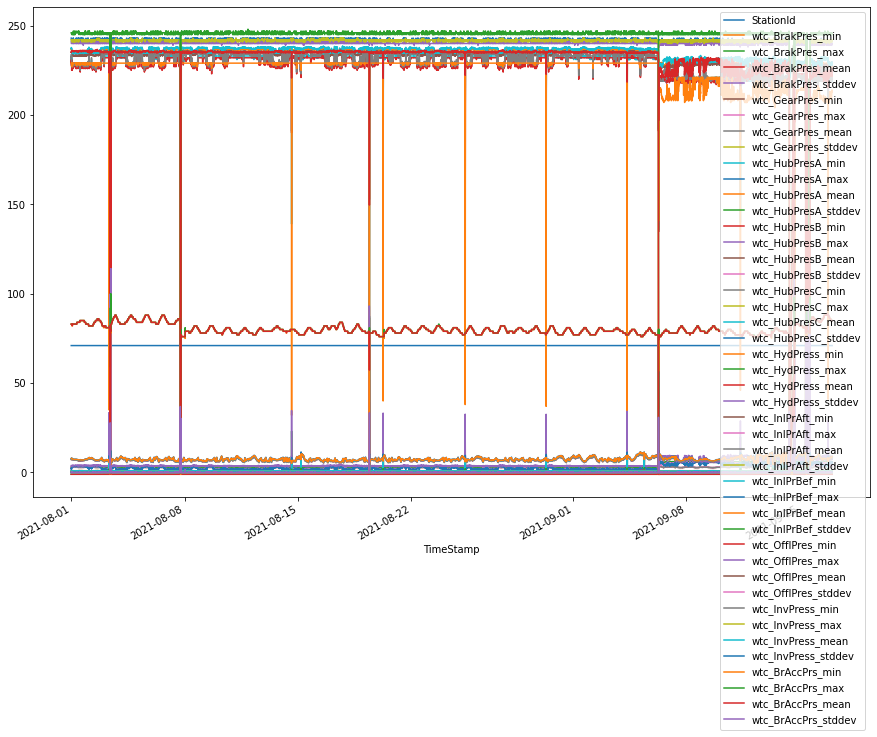

In [38]:
df5.reset_index().plot(x='TimeStamp', figsize=(15, 10))

# plt.legend(ncol=3, loc="lower left")

In [61]:
import plotly.express as px


In [144]:

fig = px.scatter(df5, y='wtc_HubPresA_max', color=df5.StationId.astype('str'))

# for i, j in enumerate(fig['data']):
#     fig['data'][i]['visible'] = 'legendonly'


fig.update_yaxes(range=[180, 250])

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        # tick0 = 0.5,
        # dtick = 0.75
    )
)

fig.show()

fig.write_image("./images/hubPresA.svg", width=1080, height=360)

### pression std_dev moyenne 3 mois avt maj vs apres maj

In [78]:
def comp_prs_stddev(df):
    
    sw_update_dt = df6[df.name]
    
    df_before = df.query('TimeStamp < @sw_update_dt').wtc_HubPresA_stddev.mean()
    df_after = df.query('TimeStamp >= @sw_update_dt').wtc_HubPresA_stddev.mean()
    
    return pd.DataFrame([[df_before, df_after]], columns=['BeforeUpdate', 'AfterUpdate'])



In [131]:
alarmcodes = [1014]

df6 = cumul_main_result_sum.query(
    'Alarmcode.isin(@alarmcodes)').groupby('StationId').first().TimeOn.dt.ceil('10min')

df6

StationId
1     2021-07-12 05:10:00
2     2021-07-12 05:10:00
3     2021-07-12 05:10:00
5     2021-07-12 05:10:00
6     2021-07-12 05:10:00
              ...        
104   2021-09-06 10:40:00
105   2021-09-06 10:40:00
106   2021-09-06 10:40:00
107   2021-09-06 10:40:00
108   2021-09-06 10:40:00
Name: TimeOn, Length: 102, dtype: datetime64[ns]

In [145]:
df6[2]

Timestamp('2021-07-12 05:10:00')

In [54]:
df7 = prs_cumul.query('StationId.isin(@df6.index)')[['TimeStamp', 'StationId', 'wtc_HubPresA_stddev']]
df7

TimeStamp  StationId  wtc_HubPresA_stddev
0      2021-06-01          1             2.523765
1      2021-06-01          2             2.482203
2      2021-06-01          3             3.015312
4      2021-06-01          5             2.304620
5      2021-06-01          6             3.271107
...           ...        ...                  ...
298590 2021-09-17        104             5.410668
298591 2021-09-17        105             4.477547
298592 2021-09-17        106             5.409760
298593 2021-09-17        107             0.000000
298594 2021-09-17        108             5.576397

[1572553 rows x 3 columns]

In [80]:
df8 = df7.groupby('StationId').apply(comp_prs_stddev).reset_index(1, drop=True)

df8

BeforeUpdate  AfterUpdate
StationId                           
1              2.998024     4.807578
2              2.771826     5.724399
3              3.139813     5.499185
5              2.518854     4.564440
6              3.281881     5.482499
...                 ...          ...
104            3.137069     5.584694
105            2.895998     5.117144
106            3.223032     5.510303
107            3.266557     5.472762
108            3.390829     5.822177

[102 rows x 2 columns]

In [134]:

fig = px.scatter(
    df8, title='wtc_HubPresA_stddev moyenne avant et apres SW update')

fig.update_layout(
    # xaxis = dict(
    #     tickmode = 'linear',
    #     # tick0 = 0.5,
    #     # dtick = 0.75
    # )
    title={
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 12},
        'pad': {'b': 0, 't': 0}},

    margin={'t': 60, 'b': 10, 'l': 10, 'r': 0})

fig.show()


In [141]:
df8.sort_values('AfterUpdate', ascending=False).head(20)


BeforeUpdate  AfterUpdate
StationId                           
27             3.146214     6.393075
90             3.118603     6.298669
67             3.610356     6.266407
42             3.036335     6.198413
98             3.349043     6.144905
13             3.287830     6.099673
54             3.337245     6.084680
25             3.171632     6.057983
23             3.042569     6.043619
59             3.189633     5.973852
84             2.555030     5.964498
63             3.327359     5.913959
94             3.083411     5.900021
48             3.033819     5.899159
85             2.962421     5.898918
37             3.045203     5.897453
46             2.313114     5.882974
11             3.195119     5.834813
108            3.390829     5.822177
62             3.321087     5.784426

# Refus ajustement

In [134]:
wps_alarms_list = pd.read_excel('wps_alarms_list.xlsx')

perte_comm = pd.read_excel('perte_comm 02-2021.xlsx')
perte_comm['StationId'] = perte_comm['StationId'].str[1:4].str.lstrip('0').astype(int)

df = pd.merge(cumul_alarms,
               wps_alarms_list,
               on='Alarmcode',
               how='left', sort=False)

df = df.merge(cumul_alarms_result_sum,
                on=['TimeOn', 'StationId',
                    'Alarmcode', 'ID', 'Parameter'],
                how='left')

df['Parameter'] = df['Parameter'].str.strip()

In [194]:
perte_comm['StationId'].to_clipboard(index=False)

In [185]:
def foo(df_foo):

    StationId = df_foo.StationId
    TimeOn = df_foo.TimeOn
    TimeOff = df_foo.TimeOff

    df_foo = cumul_results.query(
        'StationId == @StationId & @TimeOn <= TimeStamp <= @TimeOff')[['ELNX', 'EL']].sum()

    return df_foo


In [ ]:
def foo(df_foo):

    StationId = df_foo.StationId
    TimeOn = df_foo.TimeOn
    TimeOff = df_foo.TimeOff

    mask = cumul_results.StationId == StationId & (
        TimeOn <= cumul_results.TimeStamp) & (cumul_results.TimeStamp <= TimeOff)
    cumul_results.loc[mask, 'ELX'] = cumul_results.loc[mask,
                                                       'ELX'] + cumul_results.loc[mask, 'ELNX']
    cumul_results.loc[mask, 'ELNX'] = 0

    return 0


In [186]:
perte_comm.apply(foo, axis=1, result_type= 'expand').sum()

ELNX    216660.203125
EL      217029.468750
dtype: float32

In [189]:
Ep_cumul = cumul_results['wtc_kWG1TotE_accum'].sum()
EL_cumul = cumul_results['EL'].sum()
ELX_cumul = cumul_results['ELX'].sum() + 216660.203125
ELNX_cumul = cumul_results['ELNX'].sum() - 216660.203125
EL_2006_cumul = cumul_results['EL_2006'].sum()
EL_PowerRed_cumul = cumul_results['EL_PowerRed'].sum()
EL_Misassigned_cumul = cumul_results['EL_Misassigned'].sum()

ELX_eq_cumul = ELX_cumul - EL_Misassigned_cumul
ELNX_eq_cumul = ELNX_cumul + EL_2006_cumul + EL_PowerRed_cumul + EL_Misassigned_cumul
Epot_eq_cumul = Ep_cumul + ELX_eq_cumul + ELNX_eq_cumul

MAA_cumul_brut = round(100 * (
    Ep_cumul + ELX_cumul) / (
        Ep_cumul + ELX_cumul + ELNX_cumul + EL_2006_cumul + EL_PowerRed_cumul), 2)

MAA_cumul_brut_mis = round(100 * (
    Ep_cumul + ELX_eq_cumul) / (Epot_eq_cumul), 2)


In [190]:
MAA_cumul_brut, MAA_cumul_brut_mis

(94.07, 94.04)

In [177]:
MAA_cumul_brut, MAA_cumul_brut_mis

(93.76, 93.73)

#  request tur 43

In [39]:
df = results.query('StationId == 43')

In [40]:
Ep_43 = df['wtc_kWG1TotE_accum'].sum()
EL_43 = df['EL'].sum()
ELX_43 = df['ELX'].sum()
ELNX_43 = df['ELNX'].sum()
EL_2006_43 = df['EL_2006'].sum()
EL_PowerRed_43 = df['EL_PowerRed'].sum()
EL_Misassigned_43 = df['EL_Misassigned'].sum()
EL_indefini_left_43 = df['EL_indefini_left'].sum()

ELX_eq_43 = ELX_43 - EL_Misassigned_43
ELNX_eq_43 = ELNX_43 + EL_2006_43 + EL_PowerRed_43 + EL_Misassigned_43 + EL_indefini_left_43
Epot_eq_43 = Ep_43 + ELX_eq_43 + ELNX_eq_43

MAA_43_brut = round(100 * (
    Ep_43 + ELX_43) / (
        Ep_43 + ELX_43 + ELNX_43 + EL_2006_43 + EL_PowerRed_43), 2)

MAA_43_brut_mis = round(100 * (
    Ep_43 + ELX_eq_43) / (Epot_eq_43), 2)


In [29]:
(Ep_43,
 ELX_eq_43,
 ELNX_eq_43,
 Epot_eq_43,
 round(100 * (ELX_eq_43) /
       (Epot_eq_43), 2),
 round(100 * (ELNX_eq_43) /
       (Epot_eq_43), 2))


(651856.0, 932.47, 396428.51, 1049216.98, 0.09, 37.78)

In [36]:
df = pd.DataFrame(index=['Turbine: 43'])

df['Energy produced (MWh)'] = round(Ep_43 / 1e3, 2)
df['Energy potential (MWh)'] = round(Epot_eq_43 / 1e3, 2)

df['Energy lost Excusable (%)'] = round(100 * (ELX_eq_43) /
                                         (Epot_eq_43), 2)
df['Energy lost Non-Excusable (%)'] = round(100 * (ELNX_eq_43) /
                                        (Epot_eq_43), 2)

df['Energy lost Excusable (MWh)'] = round(ELX_eq_43 / 1e3, 2)
df['Energy lost Non-Excusable (MWh)'] = round(ELNX_eq_43 / 1e3, 2)

df.columns.name = '.'

df


.            Energy produced (MWh)  Energy potential (MWh)  \
Turbine: 43                 651.86                 1049.22   

.            Energy lost Excusable (%)  Energy lost Non-Excusable (%)  \
Turbine: 43                       0.09                          37.78   

.            Energy lost Excusable (MWh)  Energy lost Non-Excusable (MWh)  
Turbine: 43                         0.93                           396.43

.            Energy produced (MWh)  Energy potential (MWh)  \
Turbine: 43                 651.86                 1049.22   

.            Energy lost Excusable (%)  Energy lost Non-Excusable (%)  \
Turbine: 43                       0.09                          37.78   

.            Energy lost Excusable (MWh)  Energy lost Non-Excusable (MWh)  
Turbine: 43                         0.93                           396.43